# 🥊 Pose Time Series Analysis Lab: การวิเคราะห์ท่ามวยไทยด้วย Time Series และ Angle Analysis

---

## 📋 Lab Overview

**วัตถุประสงค์การเรียนรู้ (Learning Objectives):**
1. เข้าใจโครงสร้างข้อมูล Pose Estimation ในรูปแบบ Time Series
2. วิเคราะห์และเปรียบเทียบการเคลื่อนไหวของบุคคลต่างๆ ข้ามเวลา
3. คำนวณ Joint Angles จาก Keypoint Coordinates
4. สร้าง Visualization เพื่อเปรียบเทียบท่าทางต่างๆ (Actions)
5. วิเคราะห์ Pattern ของท่ามวยไทยผ่าน Time Series และ Angle Analysis

**Prerequisites:**
- Python 3.8+
- ความเข้าใจพื้นฐานเรื่อง Pandas DataFrame
- ความเข้าใจพื้นฐานเรื่อง Trigonometry (สำหรับการคำนวณมุม)

**Estimated Time:** 2-3 hours

---

## 📚 Part 1: Environment Setup และ Data Loading

ในส่วนนี้เราจะเตรียมสภาพแวดล้อมสำหรับการวิเคราะห์ โดยการ import libraries ที่จำเป็น
และโหลดข้อมูล Pose Estimation จากไฟล์ CSV

### 1.1 Import Libraries

**อธิบาย:** นำเข้า libraries ที่จำเป็นสำหรับการวิเคราะห์ Time Series และการสร้าง Visualization

| Library | หน้าที่ |
|---------|--------|
| pandas | จัดการข้อมูลในรูปแบบ DataFrame |
| numpy | การคำนวณเชิงตัวเลขและ array operations |
| matplotlib | สร้างกราฟและ visualization พื้นฐาน |
| seaborn | สร้างกราฟสถิติที่สวยงาม |
| scipy | Signal processing และ smoothing |

In [25]:
# =====================================================
# STEP 1.1: Import Required Libraries
# =====================================================
# 📝 Description: 
# นำเข้า libraries ทั้งหมดที่จำเป็นสำหรับการวิเคราะห์
# - pandas: สำหรับจัดการข้อมูล DataFrame
# - numpy: สำหรับการคำนวณเชิงตัวเลข
# - matplotlib & seaborn: สำหรับสร้างกราฟ
# - scipy: สำหรับ signal processing (smoothing)
#
# 💡 Tip: ถ้ายังไม่มี library ใดๆ ให้รัน: 
#     pip install pandas numpy matplotlib seaborn scipy
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.ndimage import uniform_filter1d
import warnings

# ตั้งค่า Visualization ให้แสดงผลสวยงาม
plt.rcParams['figure.figsize'] = (14, 8)      # ขนาดรูปเริ่มต้น
plt.rcParams['font.size'] = 11                 # ขนาดตัวอักษร
plt.rcParams['axes.titlesize'] = 14            # ขนาดหัวข้อกราฟ
plt.rcParams['axes.labelsize'] = 12            # ขนาด label แกน
sns.set_style("whitegrid")                     # สไตล์กราฟแบบมี grid
warnings.filterwarnings('ignore')              # ปิด warnings

# สำหรับแสดงผลภาษาไทย (ถ้ามี font)
try:
    plt.rcParams['font.family'] = 'DejaVu Sans'
except:
    pass

print("✅ Libraries imported successfully!")
print(f"   📊 Pandas version: {pd.__version__}")
print(f"   🔢 NumPy version: {np.__version__}")

✅ Libraries imported successfully!
   📊 Pandas version: 2.3.3
   🔢 NumPy version: 2.1.0


### 1.2 Load Pose Data

**อธิบาย:** โหลดข้อมูล Pose Estimation จากไฟล์ CSV

**โครงสร้างข้อมูล (Data Structure):**

```
┌─────────────────────────────────────────────────────────────┐
│                    POSE DATA STRUCTURE                      │
├─────────────────────────────────────────────────────────────┤
│ frame_idx      : หมายเลขเฟรม (ดัชนีเวลา)                    │
│ timestamp      : เวลาในหน่วยวินาที                          │
│ person_id      : รหัสบุคคลที่ถูกติดตาม                      │
│ avg_confidence : ความเชื่อมั่นเฉลี่ยของ keypoints           │
│ keypoint_x     : พิกัด X ของแต่ละ keypoint                  │
│ keypoint_y     : พิกัด Y ของแต่ละ keypoint                  │
│ keypoint_conf  : ความเชื่อมั่นของแต่ละ keypoint             │
│ action         : ป้ายกำกับท่าทาง (Label)                    │
└─────────────────────────────────────────────────────────────┘
```

**Keypoints ทั้งหมด 17 จุด:**
```
       nose (0)
    left_eye (1)  right_eye (2)
    left_ear (3)  right_ear (4)
        |
  left_shoulder (5) ─── right_shoulder (6)
        |                    |
   left_elbow (7)      right_elbow (8)
        |                    |
   left_wrist (9)      right_wrist (10)
        |                    |
    left_hip (11) ──── right_hip (12)
        |                    |
   left_knee (13)      right_knee (14)
        |                    |
  left_ankle (15)     right_ankle (16)
```

In [26]:
# =====================================================
# STEP 1.2: Load Pose Data from CSV
# =====================================================
# 📝 Description: 
# โหลดข้อมูลจากไฟล์ CSV ที่เตรียมไว้
# ไฟล์นี้ประกอบด้วยข้อมูล pose estimation ของหลายคน
# ที่ถูก track ข้ามเฟรม พร้อม action labels
#
# 🔄 Process:
# 1. อ่านไฟล์ CSV ด้วย pd.read_csv()
# 2. แสดงข้อมูลเบื้องต้นเพื่อตรวจสอบความถูกต้อง
# 3. ดูโครงสร้างและขนาดของข้อมูล
#
# ⚠️ Note: ตรวจสอบว่าไฟล์ 'pose_data.csv' อยู่ใน directory เดียวกัน
# =====================================================

# โหลดข้อมูล
df_pose = pd.read_csv('pose_data.csv')

# แสดงข้อมูลเบื้องต้น
print("=" * 70)
print("📊 POSE DATA OVERVIEW")
print("=" * 70)
print(f"\n📁 Dataset Shape: {df_pose.shape[0]:,} rows × {df_pose.shape[1]} columns")
print(f"📅 Frame Range: {df_pose['frame_idx'].min()} to {df_pose['frame_idx'].max()}")
print(f"⏱️  Time Range: {df_pose['timestamp'].min():.2f}s to {df_pose['timestamp'].max():.2f}s")
print(f"👥 Unique Persons: {df_pose['person_id'].nunique()}")
print(f"🎯 Actions: {df_pose['action'].nunique()}")

print("\n" + "=" * 70)
print("📋 DATA SAMPLE (First 5 rows)")
print("=" * 70)
display(df_pose.head())

📊 POSE DATA OVERVIEW

📁 Dataset Shape: 34,884 rows × 56 columns
📅 Frame Range: 0 to 3865
⏱️  Time Range: 0.00s to 133.28s
👥 Unique Persons: 36
🎯 Actions: 6

📋 DATA SAMPLE (First 5 rows)


frame_idx  timestamp  person_id  avg_confidence       nose_x      nose_y  \
0          0        0.0          1        0.939729  1570.841064  628.137329   
1          0        0.0          2        0.857351  1391.924805  541.764343   
2          0        0.0          3        0.877679  1112.941162  528.165833   
3          0        0.0          4        0.883166   915.781311  563.037415   
4          0        0.0          5        0.714610   292.317749  626.045166   

   nose_conf   left_eye_x  left_eye_y  left_eye_conf  ...  right_knee_x  \
0   0.989106  1579.320312  621.487305       0.991083  ...   1542.994385   
1   0.983361  1398.174927  537.000183       0.991576  ...   1391.394531   
2   0.985352  1119.043701  523.015991       0.990616  ...   1112.048828   
3   0.987232   923.174805  557.466187       0.992261  ...    915.727478   
4   0.435317   294.536560  619.495117       0.544087  ...    325.843323   

   right_knee_y  right_knee_conf  left_ankle_x  left_ankle_y  left_ankle_conf  \
0    847.923523         0.997359   1597.515137    943.138306         0.990762   
1    713.093384         0.992637   1429.300781    784.686035         0.997721   
2    700.252930         0.993971   1146.626831    774.413330         0.996617   
3    763.843018         0.989884    947.519165    849.709167         0.996019   
4    836.402527         0.973125    349.057526    931.232117         0.988034   

   right_ankle_x  right_ankle_y  right_ankle_conf              action  
0    1544.355225     926.163391          0.990130  Mek_Khara_Lor_Kaew  
1    1389.803467     773.052124          0.991802  Mek_Khara_Lor_Kaew  
2    1112.166382     761.413574          0.991508  Mek_Khara_Lor_Kaew  
3     917.615662     825.769226          0.987224  Mek_Khara_Lor_Kaew  
4     330.143982     914.861084          0.956085  Mek_Khara_Lor_Kaew  

[5 rows x 56 columns]

In [27]:
# =====================================================
# STEP 1.3: Data Info Summary
# =====================================================
# 📝 Description: 
# แสดงรายละเอียดของ columns ทั้งหมด
# เพื่อให้เข้าใจโครงสร้างข้อมูล
#
# 🔍 สิ่งที่ต้องตรวจสอบ:
# - จำนวน Non-Null Count ของแต่ละ column
# - Dtype ของแต่ละ column
# - Memory usage
# =====================================================

print("=" * 70)
print("📋 DATA STRUCTURE INFO")
print("=" * 70)
print(f"\n📊 Column Types:")
print(f"   - float64 (coordinates & confidence): 53 columns")
print(f"   - int64 (frame_idx, person_id): 2 columns")
print(f"   - object (action label): 1 column")
print(f"\n💾 Memory Usage: ~14.9 MB")
print("\n" + "-" * 70)
df_pose.info()

📋 DATA STRUCTURE INFO

📊 Column Types:
   - float64 (coordinates & confidence): 53 columns
   - int64 (frame_idx, person_id): 2 columns
   - object (action label): 1 column

💾 Memory Usage: ~14.9 MB

----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34884 entries, 0 to 34883
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frame_idx            34884 non-null  int64  
 1   timestamp            34884 non-null  float64
 2   person_id            34884 non-null  int64  
 3   avg_confidence       34884 non-null  float64
 4   nose_x               34884 non-null  float64
 5   nose_y               34884 non-null  float64
 6   nose_conf            34884 non-null  float64
 7   left_eye_x           34884 non-null  float64
 8   left_eye_y           34884 non-null  float64
 9   left_eye_conf        34884 non-null  float64
 10  right_eye_x    

### 1.3 Define Constants

**อธิบาย:** กำหนดค่าคงที่สำหรับ COCO Keypoint format และ Skeleton Connections

**COCO Keypoint Format:**
- มาตรฐานสากลสำหรับ Human Pose Estimation
- ประกอบด้วย 17 keypoints ครอบคลุมทั้งร่างกาย
- แต่ละ keypoint มีพิกัด (x, y) และค่า confidence

**ภาพประกอบ Skeleton Connections:**
```
             ○ nose
            /|\
    left_eye ○ ○ right_eye
           /   \
  left_ear ○     ○ right_ear
                  
   left_shoulder ○───○ right_shoulder
                 |   |
                 │   │
     left_elbow ○   ○ right_elbow
                 │   │
     left_wrist ○   ○ right_wrist
                 │   │
       left_hip ○───○ right_hip
                 │   │
      left_knee ○   ○ right_knee
                 │   │
     left_ankle ○   ○ right_ankle
```

In [28]:
# =====================================================
# STEP 1.4: Define COCO Keypoint Constants
# =====================================================
# 📝 Description: 
# กำหนดชื่อ Keypoints ตามมาตรฐาน COCO
# COCO format มี 17 keypoints ครอบคลุมทั้งร่างกาย
#
# 🎯 Purpose:
# - ใช้อ้างอิงชื่อ keypoints อย่างเป็นระบบ
# - จัดกลุ่มส่วนต่างๆ ของร่างกายเพื่อการวิเคราะห์
# - กำหนดเส้นเชื่อมสำหรับการวาด skeleton
# =====================================================

# รายชื่อ Keypoints (17 จุด) พร้อมดัชนี
KEYPOINT_NAMES = [
    "nose",           # 0 - จมูก
    "left_eye",       # 1 - ตาซ้าย
    "right_eye",      # 2 - ตาขวา
    "left_ear",       # 3 - หูซ้าย
    "right_ear",      # 4 - หูขวา
    "left_shoulder",  # 5 - ไหล่ซ้าย
    "right_shoulder", # 6 - ไหล่ขวา
    "left_elbow",     # 7 - ข้อศอกซ้าย
    "right_elbow",    # 8 - ข้อศอกขวา
    "left_wrist",     # 9 - ข้อมือซ้าย
    "right_wrist",    # 10 - ข้อมือขวา
    "left_hip",       # 11 - สะโพกซ้าย
    "right_hip",      # 12 - สะโพกขวา
    "left_knee",      # 13 - เข่าซ้าย
    "right_knee",     # 14 - เข่าขวา
    "left_ankle",     # 15 - ข้อเท้าซ้าย
    "right_ankle"     # 16 - ข้อเท้าขวา
]

# การจัดกลุ่มส่วนต่างๆ ของร่างกาย (สำหรับการวิเคราะห์เฉพาะส่วน)
BODY_PARTS = {
    'head': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear'],
    'upper_body': ['left_shoulder', 'right_shoulder', 'left_elbow', 
                   'right_elbow', 'left_wrist', 'right_wrist'],
    'lower_body': ['left_hip', 'right_hip', 'left_knee', 
                   'right_knee', 'left_ankle', 'right_ankle'],
    'left_arm': ['left_shoulder', 'left_elbow', 'left_wrist'],
    'right_arm': ['right_shoulder', 'right_elbow', 'right_wrist'],
    'left_leg': ['left_hip', 'left_knee', 'left_ankle'],
    'right_leg': ['right_hip', 'right_knee', 'right_ankle'],
    'torso': ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
}

# เส้นเชื่อมสำหรับ Skeleton Visualization
SKELETON_CONNECTIONS = [
    # Head connections
    ('nose', 'left_eye'), ('nose', 'right_eye'),
    ('left_eye', 'left_ear'), ('right_eye', 'right_ear'),
    # Upper body
    ('left_shoulder', 'right_shoulder'),  # shoulders
    ('left_shoulder', 'left_elbow'), ('left_elbow', 'left_wrist'),
    ('right_shoulder', 'right_elbow'), ('right_elbow', 'right_wrist'),
    # Torso
    ('left_shoulder', 'left_hip'), ('right_shoulder', 'right_hip'),
    ('left_hip', 'right_hip'),
    # Lower body
    ('left_hip', 'left_knee'), ('left_knee', 'left_ankle'),
    ('right_hip', 'right_knee'), ('right_knee', 'right_ankle')
]

print("✅ Constants defined!")
print(f"   📍 Total Keypoints: {len(KEYPOINT_NAMES)}")
print(f"   🦴 Body Parts Groups: {list(BODY_PARTS.keys())}")
print(f"   🔗 Skeleton Connections: {len(SKELETON_CONNECTIONS)}")

# แสดงตารางสรุป Keypoints
print("\n" + "=" * 70)
print("📋 KEYPOINT REFERENCE TABLE")
print("=" * 70)
keypoint_df = pd.DataFrame({
    'Index': range(len(KEYPOINT_NAMES)),
    'Keypoint Name': KEYPOINT_NAMES,
    'Thai Name': ['จมูก', 'ตาซ้าย', 'ตาขวา', 'หูซ้าย', 'หูขวา',
                  'ไหล่ซ้าย', 'ไหล่ขวา', 'ข้อศอกซ้าย', 'ข้อศอกขวา',
                  'ข้อมือซ้าย', 'ข้อมือขวา', 'สะโพกซ้าย', 'สะโพกขวา',
                  'เข่าซ้าย', 'เข่าขวา', 'ข้อเท้าซ้าย', 'ข้อเท้าขวา']
})
print(keypoint_df.to_string(index=False))

✅ Constants defined!
   📍 Total Keypoints: 17
   🦴 Body Parts Groups: ['head', 'upper_body', 'lower_body', 'left_arm', 'right_arm', 'left_leg', 'right_leg', 'torso']
   🔗 Skeleton Connections: 16

📋 KEYPOINT REFERENCE TABLE
 Index  Keypoint Name   Thai Name
     0           nose        จมูก
     1       left_eye      ตาซ้าย
     2      right_eye       ตาขวา
     3       left_ear      หูซ้าย
     4      right_ear       หูขวา
     5  left_shoulder    ไหล่ซ้าย
     6 right_shoulder     ไหล่ขวา
     7     left_elbow  ข้อศอกซ้าย
     8    right_elbow   ข้อศอกขวา
     9     left_wrist  ข้อมือซ้าย
    10    right_wrist   ข้อมือขวา
    11       left_hip   สะโพกซ้าย
    12      right_hip    สะโพกขวา
    13      left_knee    เข่าซ้าย
    14     right_knee     เข่าขวา
    15     left_ankle ข้อเท้าซ้าย
    16    right_ankle  ข้อเท้าขวา


---

## 📚 Part 2: Exploratory Data Analysis (EDA)

ในส่วนนี้เราจะสำรวจข้อมูลเพื่อเข้าใจลักษณะและการกระจายตัวของข้อมูล

### 2.1 Action Distribution Analysis

**อธิบาย:** วิเคราะห์การกระจายตัวของ Actions ต่างๆ ในข้อมูล

**ทำไมต้องวิเคราะห์ Action Distribution?**
- เพื่อดูความสมดุลของข้อมูล (Class Balance)
- ระบุ Actions ที่มีข้อมูลมาก/น้อย
- วางแผนการวิเคราะห์และ sampling strategy

🎯 ACTION DISTRIBUTION

📋 Summary Table:
              Action  Count  Percentage (%)
Kum_PaGUN_Poong_Hork   7229           20.72
          Hoang_Hern   7056           20.23
     Narai_Kwang_Jug   6591           18.89
             Unknown   5282           15.14
   PhraRam_Phangsorn   4551           13.05
  Mek_Khara_Lor_Kaew   4175           11.97


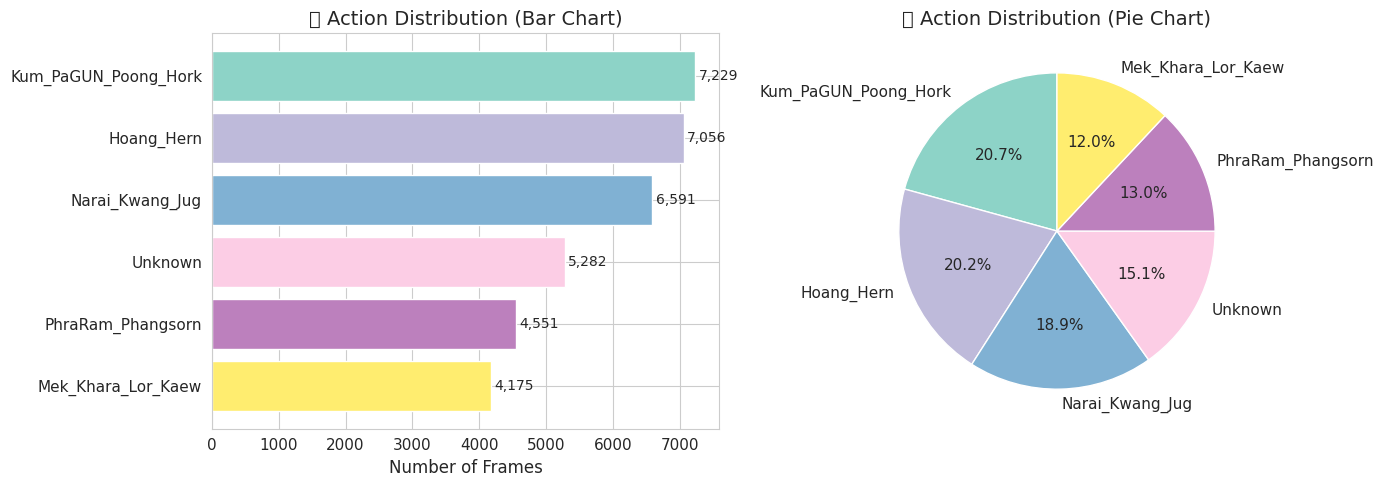

In [29]:
# =====================================================
# STEP 2.1: Action Distribution Analysis
# =====================================================
# 📝 Description: 
# วิเคราะห์จำนวนและสัดส่วนของแต่ละ Action
# เพื่อเข้าใจความสมดุลของข้อมูล
#
# 📊 Output:
# - ตารางแสดงจำนวน frames ต่อ action
# - Bar chart แสดงการกระจายตัว
# - Pie chart แสดงสัดส่วน
#
# 💡 Insight:
# ถ้า action ใดมีข้อมูลน้อยเกินไป อาจต้องระวัง
# เรื่อง bias ในการวิเคราะห์
# =====================================================

# นับจำนวนแต่ละ Action
action_counts = df_pose['action'].value_counts()
action_percentages = df_pose['action'].value_counts(normalize=True) * 100

print("=" * 70)
print("🎯 ACTION DISTRIBUTION")
print("=" * 70)

# แสดงตาราง
action_summary = pd.DataFrame({
    'Action': action_counts.index,
    'Count': action_counts.values,
    'Percentage (%)': action_percentages.values.round(2)
})
print("\n📋 Summary Table:")
print(action_summary.to_string(index=False))

# สร้าง Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar Chart
colors = plt.cm.Set3(np.linspace(0, 1, len(action_counts)))
bars = axes[0].barh(action_counts.index, action_counts.values, color=colors)
axes[0].set_xlabel('Number of Frames')
axes[0].set_title('📊 Action Distribution (Bar Chart)')
axes[0].invert_yaxis()

# เพิ่มตัวเลขบน bar
for bar, count in zip(bars, action_counts.values):
    axes[0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                 f'{count:,}', va='center', fontsize=10)

# Pie Chart
axes[1].pie(action_counts.values, labels=action_counts.index, 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('📊 Action Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### 2.2 Person ID Analysis

**อธิบาย:** วิเคราะห์จำนวน Frames ต่อ Person และ Person ต่อ Action

**คำถามที่ต้องการตอบ:**
1. แต่ละ Person มีกี่ frames?
2. แต่ละ Action มี Person กี่คนที่ทำ?
3. ข้อมูลกระจายตัวสม่ำเสมอหรือไม่?

👥 PERSON ID ANALYSIS

📋 Frames per Person (Top 10):
 person_id  frame_count
         2         3866
         6         3862
         4         3859
        16         3325
         7         2930
         8         2124
        22         2075
         5         1803
         3         1639
         9         1352

📊 Statistics:
   Total Unique Persons: 36
   Max Frames per Person: 3,866
   Min Frames per Person: 1
   Mean Frames per Person: 969.00
   Median Frames per Person: 336.00

🎯 PERSONS PER ACTION
              Action  Unique Persons
          Hoang_Hern              15
Kum_PaGUN_Poong_Hork              11
  Mek_Khara_Lor_Kaew              14
     Narai_Kwang_Jug              16
   PhraRam_Phangsorn              14
             Unknown              20


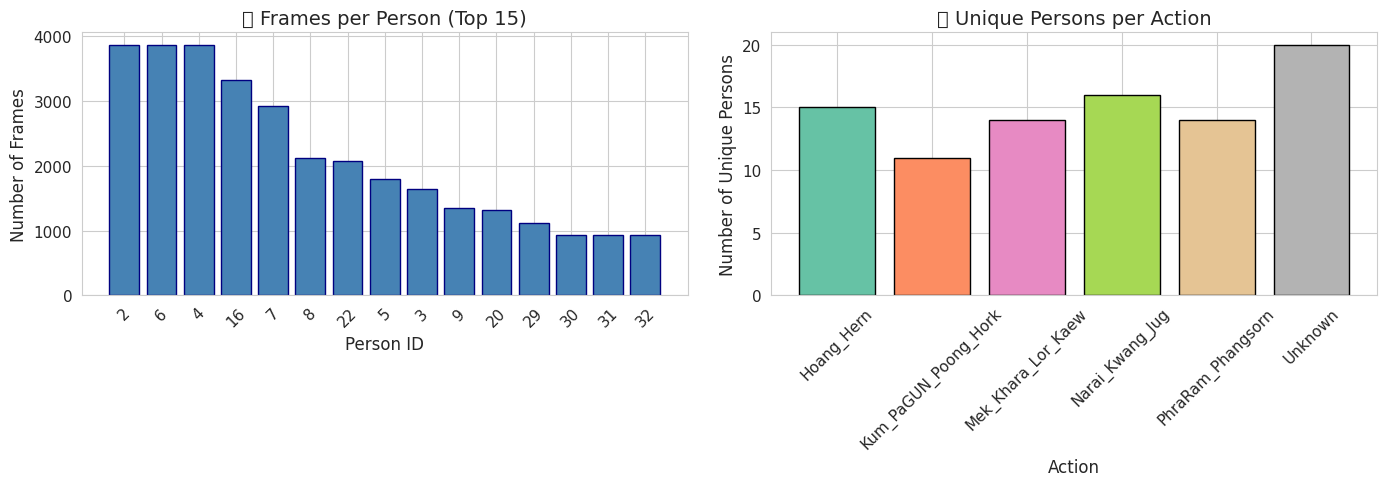

In [30]:
# =====================================================
# STEP 2.2: Person ID Analysis
# =====================================================
# 📝 Description: 
# วิเคราะห์ว่าแต่ละ Person มีกี่ frames
# และแต่ละ Action มี Person กี่คน
#
# 🎯 Purpose:
# - ตรวจสอบความครอบคลุมของข้อมูล
# - หา Persons ที่มีข้อมูลเพียงพอสำหรับการวิเคราะห์
# - ดูความหลากหลายของผู้ทำแต่ละ action
# =====================================================

# นับ frames ต่อ person
person_frame_counts = df_pose.groupby('person_id').size().reset_index(name='frame_count')
person_frame_counts = person_frame_counts.sort_values('frame_count', ascending=False)

print("=" * 70)
print("👥 PERSON ID ANALYSIS")
print("=" * 70)

print("\n📋 Frames per Person (Top 10):")
print(person_frame_counts.head(10).to_string(index=False))

print(f"\n📊 Statistics:")
print(f"   Total Unique Persons: {len(person_frame_counts)}")
print(f"   Max Frames per Person: {person_frame_counts['frame_count'].max():,}")
print(f"   Min Frames per Person: {person_frame_counts['frame_count'].min():,}")
print(f"   Mean Frames per Person: {person_frame_counts['frame_count'].mean():.2f}")
print(f"   Median Frames per Person: {person_frame_counts['frame_count'].median():.2f}")

# Person distribution per action
print("\n" + "=" * 70)
print("🎯 PERSONS PER ACTION")
print("=" * 70)

person_per_action = df_pose.groupby('action')['person_id'].nunique().reset_index()
person_per_action.columns = ['Action', 'Unique Persons']
print(person_per_action.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frames per person (top 15)
top_persons = person_frame_counts.head(15)
axes[0].bar(top_persons['person_id'].astype(str), top_persons['frame_count'], 
            color='steelblue', edgecolor='navy')
axes[0].set_xlabel('Person ID')
axes[0].set_ylabel('Number of Frames')
axes[0].set_title('👥 Frames per Person (Top 15)')
axes[0].tick_params(axis='x', rotation=45)

# Persons per action
colors = plt.cm.Set2(np.linspace(0, 1, len(person_per_action)))
axes[1].bar(person_per_action['Action'], person_per_action['Unique Persons'], 
            color=colors, edgecolor='black')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Number of Unique Persons')
axes[1].set_title('🎯 Unique Persons per Action')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.3 Select 3 Representative Person IDs for Analysis

**อธิบาย:** เลือก 3 Person IDs ที่มีข้อมูลครบถ้วนสำหรับการวิเคราะห์เปรียบเทียบ

**เกณฑ์การเลือก:**
1. มี labeled frames มากที่สุด (ไม่ใช่ 'Unknown')
2. ปรากฏในหลาย actions
3. มีช่วงเวลาต่อเนื่องยาวพอสำหรับ time series analysis

```
┌─────────────────────────────────────────────┐
│          SELECTION CRITERIA                 │
├─────────────────────────────────────────────┤
│ ✓ Labeled frames (not 'Unknown')           │
│ ✓ Multiple actions performed               │
│ ✓ Continuous time series                   │
│ ✓ High confidence keypoints                │
└─────────────────────────────────────────────┘
```

In [31]:
# =====================================================
# STEP 2.3: Select 3 Representative Person IDs
# =====================================================
# 📝 Description: 
# เลือก 3 Person IDs ที่มี frames มากที่สุด
# และปรากฏใน Action labels (ไม่ใช่ Unknown)
# เพื่อใช้ในการวิเคราะห์เปรียบเทียบ
#
# 🔄 Process:
# 1. กรองเฉพาะ frames ที่มี label
# 2. นับ frames ต่อ person
# 3. เลือก top 3 persons
# 4. แสดงรายละเอียด
#
# 💡 Note: 
# การเลือก persons ที่มีข้อมูลมากช่วยให้การวิเคราะห์
# มีความน่าเชื่อถือมากขึ้น
# =====================================================

# กรองเฉพาะ frames ที่มี label (ไม่ใช่ Unknown)
df_labeled = df_pose[df_pose['action'] != 'Unknown'].copy()

print(f"📊 Filtered Data: {len(df_labeled):,} frames with labels (excluded 'Unknown')")

# นับ frames ต่อ person สำหรับข้อมูลที่มี label
person_labeled_counts = df_labeled.groupby('person_id').agg({
    'frame_idx': 'count',
    'action': lambda x: x.nunique()
}).reset_index()
person_labeled_counts.columns = ['person_id', 'labeled_frames', 'actions_count']
person_labeled_counts = person_labeled_counts.sort_values('labeled_frames', ascending=False)

print("\n" + "=" * 70)
print("🎯 SELECTING REPRESENTATIVE PERSON IDs")
print("=" * 70)

print("\n📋 Persons with Labeled Frames (Top 10):")
print(person_labeled_counts.head(10).to_string(index=False))

# เลือก 3 person IDs ที่มี frames มากที่สุด
SELECTED_PERSON_IDS = person_labeled_counts.head(3)['person_id'].tolist()

print(f"\n✅ Selected Person IDs for Analysis: {SELECTED_PERSON_IDS}")

# แสดงรายละเอียดของ selected persons
print("\n" + "=" * 70)
print("📊 SELECTED PERSONS DETAILS")
print("=" * 70)

for pid in SELECTED_PERSON_IDS:
    person_data = df_labeled[df_labeled['person_id'] == pid]
    actions = person_data['action'].unique()
    print(f"\n👤 Person ID: {pid}")
    print(f"   📈 Total Labeled Frames: {len(person_data):,}")
    print(f"   🎯 Actions: {list(actions)}")
    print(f"   📅 Frame Range: {person_data['frame_idx'].min()} - {person_data['frame_idx'].max()}")
    print(f"   ⏱️  Time Range: {person_data['timestamp'].min():.2f}s - {person_data['timestamp'].max():.2f}s")
    print(f"   📊 Duration: {person_data['timestamp'].max() - person_data['timestamp'].min():.2f}s")

📊 Filtered Data: 29,602 frames with labels (excluded 'Unknown')

🎯 SELECTING REPRESENTATIVE PERSON IDs

📋 Persons with Labeled Frames (Top 10):
 person_id  labeled_frames  actions_count
         2            3280              5
         6            3276              5
         4            3273              5
         7            2874              5
        16            2743              4
         8            2084              4
         5            1766              3
         3            1602              3
        22            1526              3
         9            1315              3

✅ Selected Person IDs for Analysis: [2, 6, 4]

📊 SELECTED PERSONS DETAILS

👤 Person ID: 2
   📈 Total Labeled Frames: 3,280
   🎯 Actions: ['Mek_Khara_Lor_Kaew', 'Kum_PaGUN_Poong_Hork', 'Narai_Kwang_Jug', 'Hoang_Hern', 'PhraRam_Phangsorn']
   📅 Frame Range: 0 - 3335
   ⏱️  Time Range: 0.00s - 115.00s
   📊 Duration: 115.00s

👤 Person ID: 6
   📈 Total Labeled Frames: 3,276
   🎯 Actions: ['Mek_K

---

## 📚 Part 3: Time Series Analysis

ในส่วนนี้เราจะวิเคราะห์การเคลื่อนไหวตามเวลา (Time Series) ของ keypoints ต่างๆ

### 3.1 Keypoint Position Time Series

**อธิบาย:** วิเคราะห์การเปลี่ยนแปลงตำแหน่ง Keypoints ตามเวลาสำหรับแต่ละ Action

**Key Keypoints สำหรับการวิเคราะห์ท่ามวย:**

| Keypoint | ความสำคัญ |
|----------|----------|
| right_wrist | การเคลื่อนไหวของหมัดขวา |
| left_wrist | การเคลื่อนไหวของหมัดซ้าย |
| right_ankle | การเคลื่อนไหวของเตะขวา |
| left_ankle | การเคลื่อนไหวของเตะซ้าย |
| nose | การเคลื่อนไหวของศีรษะ/ลำตัว |

**ภาพประกอบ Coordinate System:**
```
(0,0) ────────────────→ X (เพิ่มไปทางขวา)
  │
  │    ○ nose
  │   /|\
  │  ○ │ ○
  │    │
  ↓    │
  Y    │
(เพิ่มลงล่าง)
```

📈 KEYPOINT TIME SERIES VISUALIZATION

💡 Interpretation Guide:
   - แต่ละสีแทน action ที่แตกต่างกัน
   - แกน X: เวลา (วินาที)
   - แกน Y ซ้าย: ตำแหน่ง X (pixels) - ซ้าย/ขวา
   - แกน Y ขวา: ตำแหน่ง Y (pixels) - บน/ล่าง (inverted)

----------------------------------------------------------------------

📊 Generating plot for Person ID: 2


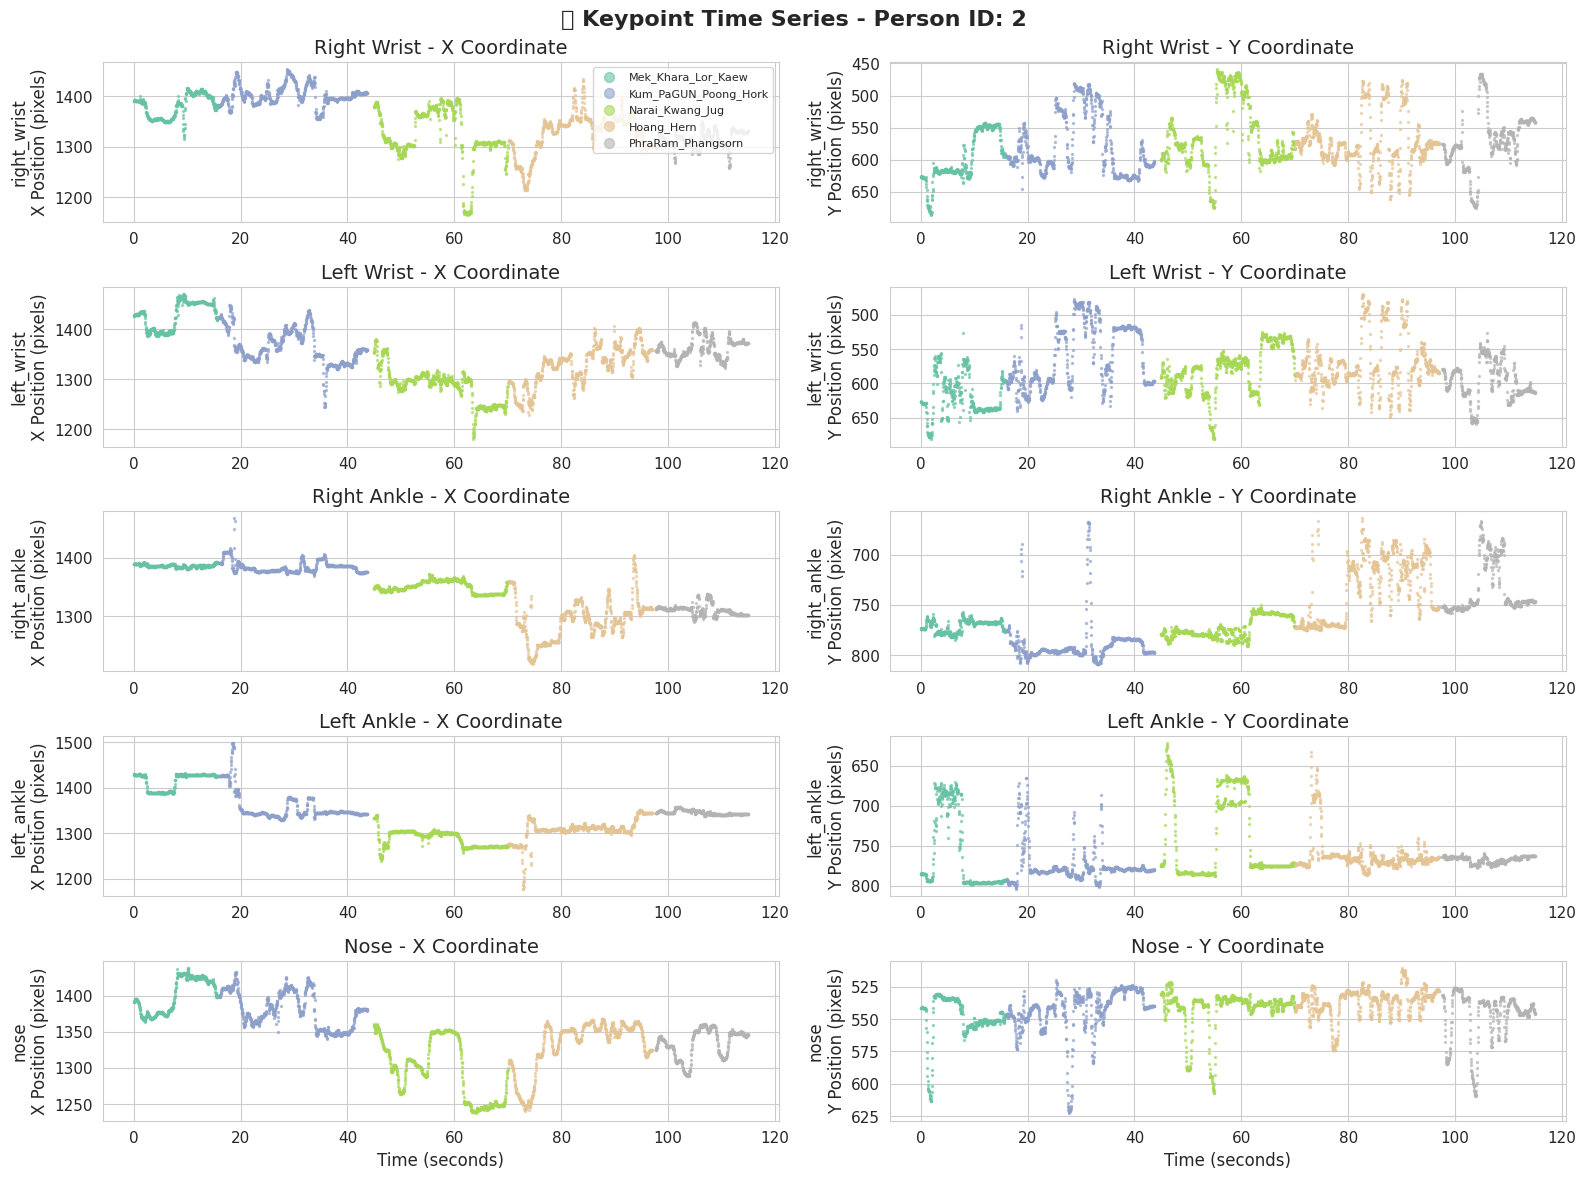


📊 Generating plot for Person ID: 6


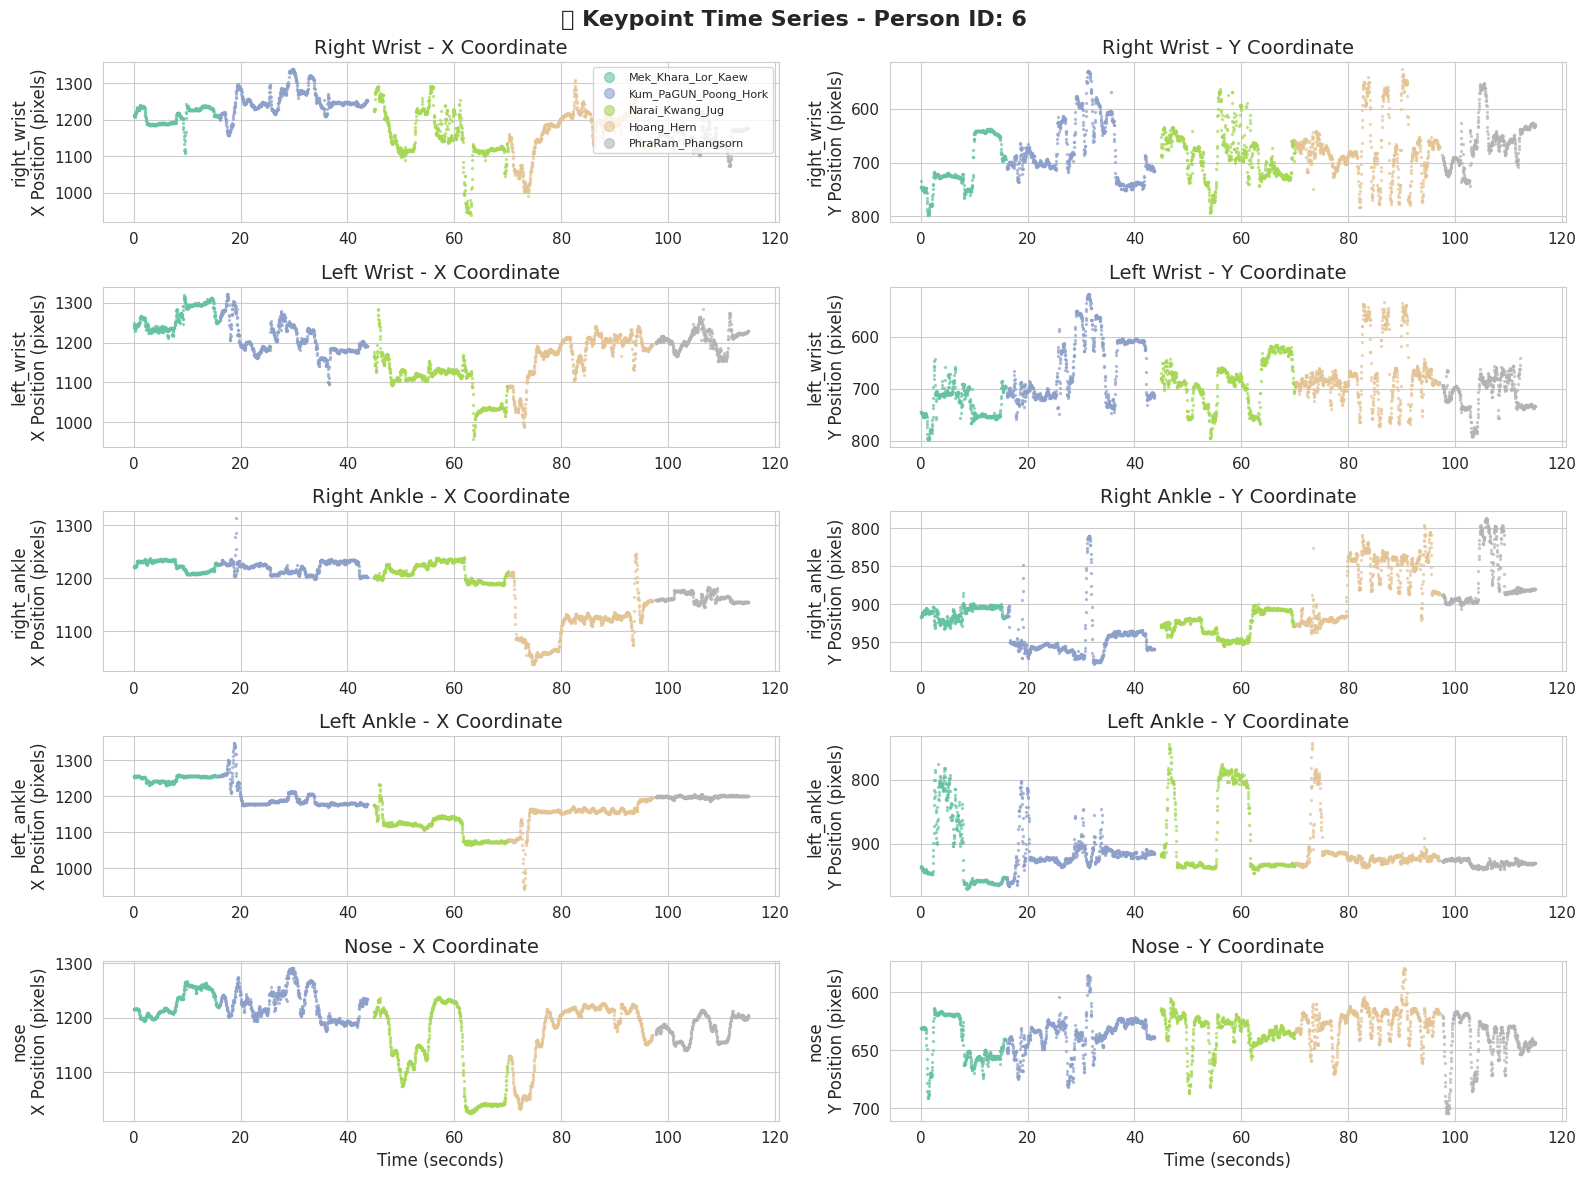


📊 Generating plot for Person ID: 4


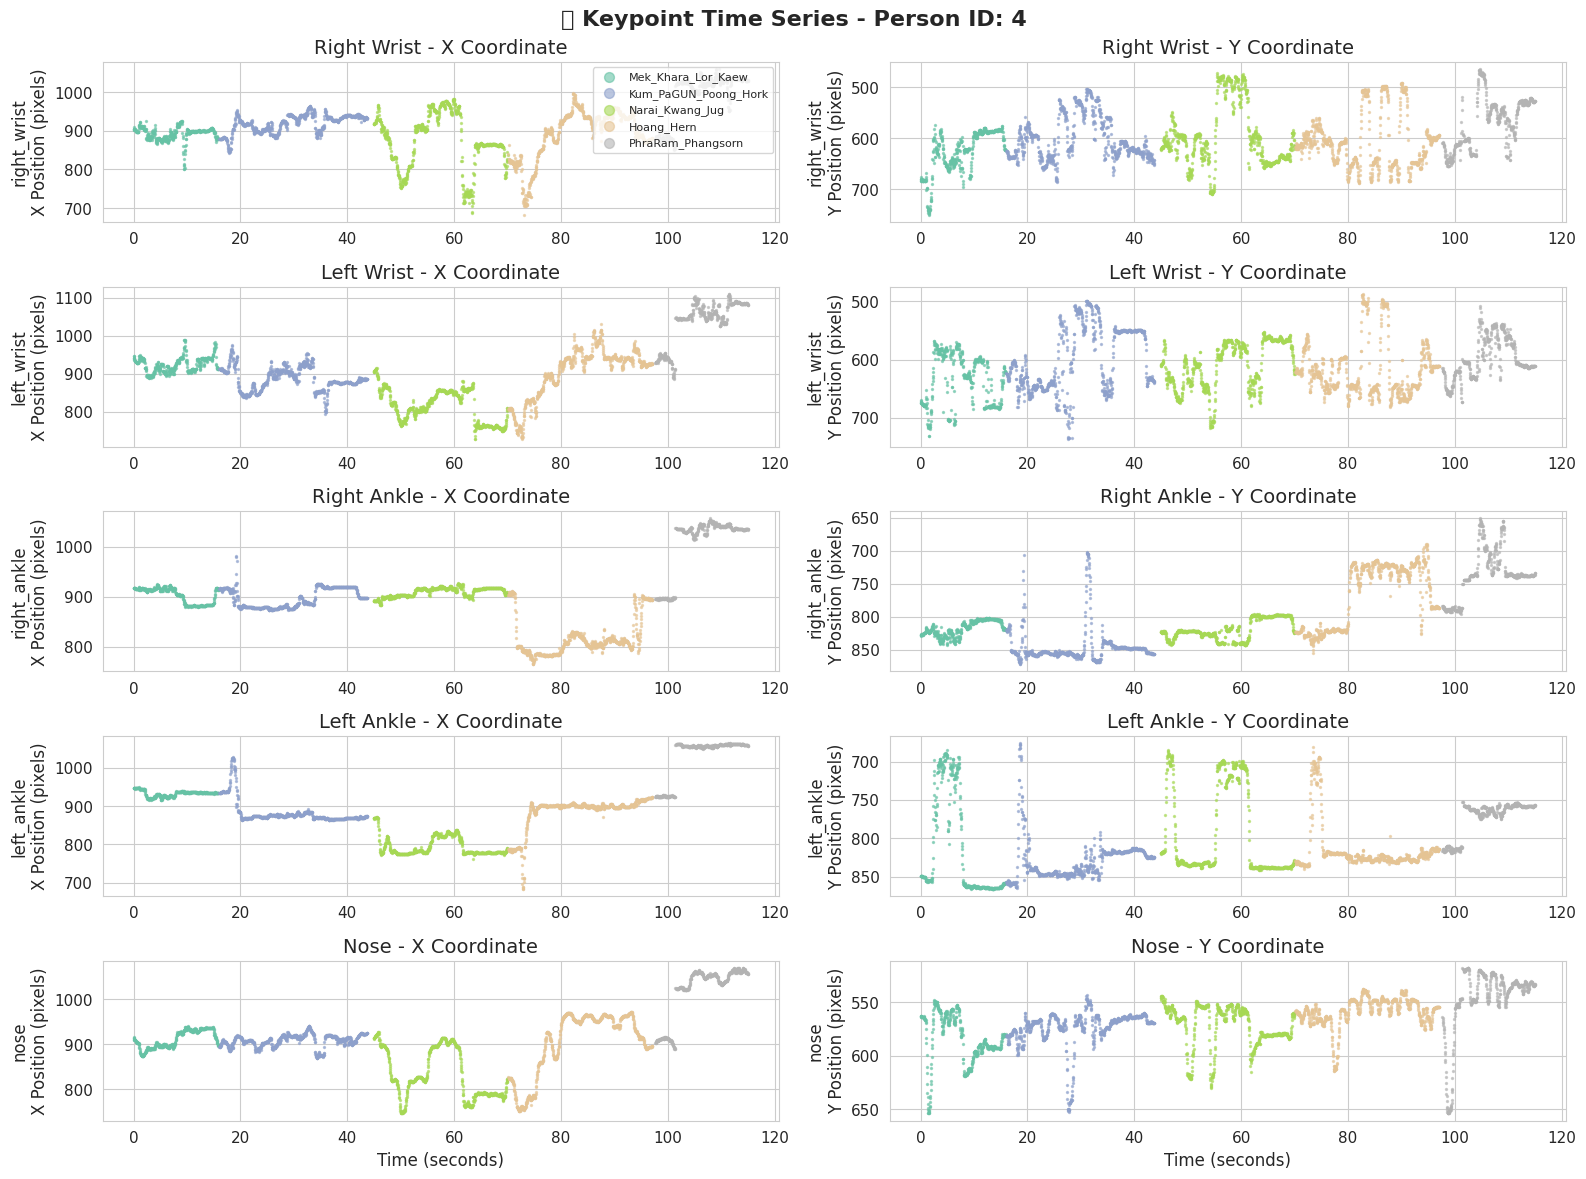

In [47]:
# =====================================================
# STEP 3.1: Keypoint Position Time Series Analysis
# =====================================================
# 📝 Description: 
# วิเคราะห์การเคลื่อนที่ของ keypoints หลักๆ ตามเวลา
# เพื่อเข้าใจ pattern การเคลื่อนไหวในแต่ละท่า
# 
# 🎯 Key Keypoints:
# - wrists: การเคลื่อนไหวของมือ (สำคัญสำหรับหมัด)
# - ankles: การเคลื่อนไหวของเท้า (สำคัญสำหรับการเตะ)
# - nose: การเคลื่อนไหวของศีรษะ
#
# 📊 Output:
# - กราฟ X coordinate ตามเวลา
# - กราฟ Y coordinate ตามเวลา
# - แยกสีตาม action
# =====================================================

# Keypoints ที่น่าสนใจสำหรับการวิเคราะห์ท่ามวย
ANALYSIS_KEYPOINTS = ['right_wrist', 'left_wrist', 'right_ankle', 'left_ankle', 'nose']

def plot_keypoint_timeseries(df, person_id, keypoints, figsize=(16, 12)):
    """
    สร้างกราฟ Time Series ของตำแหน่ง Keypoints
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose
    person_id : int - Person ID ที่ต้องการวิเคราะห์
    keypoints : list - รายชื่อ keypoints
    figsize : tuple - ขนาดรูป
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # กรองข้อมูลสำหรับ person นี้
    person_data = df[df['person_id'] == person_id].copy()
    person_data = person_data.sort_values('frame_idx')
    
    # สร้าง figure
    fig, axes = plt.subplots(len(keypoints), 2, figsize=figsize)
    fig.suptitle(f'👤 Keypoint Time Series - Person ID: {person_id}', 
                 fontsize=16, fontweight='bold')
    
    # สร้าง color map สำหรับ actions
    actions = person_data['action'].unique()
    action_colors = dict(zip(actions, plt.cm.Set2(np.linspace(0, 1, len(actions)))))
    
    for idx, kpt in enumerate(keypoints):
        # Plot X coordinate
        ax_x = axes[idx, 0]
        for action in actions:
            action_data = person_data[person_data['action'] == action]
            ax_x.scatter(action_data['timestamp'], action_data[f'{kpt}_x'], 
                        label=action, alpha=0.6, s=2, color=action_colors[action])
        
        ax_x.set_ylabel(f'{kpt}\nX Position (pixels)')
        ax_x.set_title(f'{kpt.replace("_", " ").title()} - X Coordinate')
        if idx == 0:
            ax_x.legend(loc='upper right', fontsize=8, markerscale=5)
        
        # Plot Y coordinate
        ax_y = axes[idx, 1]
        for action in actions:
            action_data = person_data[person_data['action'] == action]
            ax_y.scatter(action_data['timestamp'], action_data[f'{kpt}_y'], 
                        label=action, alpha=0.6, s=2, color=action_colors[action])
        
        ax_y.set_ylabel(f'{kpt}\nY Position (pixels)')
        ax_y.set_title(f'{kpt.replace("_", " ").title()} - Y Coordinate')
        
        # กลับแกน Y เพราะ pixel coordinate มี Y เพิ่มขึ้นเมื่อไปทางล่าง
        ax_y.invert_yaxis()
    
    # Set x labels for bottom row
    axes[-1, 0].set_xlabel('Time (seconds)')
    axes[-1, 1].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    return fig

# สร้างกราฟสำหรับ Person ID แรกที่เลือก
print("=" * 70)
print("📈 KEYPOINT TIME SERIES VISUALIZATION")
print("=" * 70)
print("\n💡 Interpretation Guide:")
print("   - แต่ละสีแทน action ที่แตกต่างกัน")
print("   - แกน X: เวลา (วินาที)")
print("   - แกน Y ซ้าย: ตำแหน่ง X (pixels) - ซ้าย/ขวา")
print("   - แกน Y ขวา: ตำแหน่ง Y (pixels) - บน/ล่าง (inverted)")
print("\n" + "-" * 70)

for pid in SELECTED_PERSON_IDS[:3]:  # แสดงเฉพาะ person แรก
    print(f"\n📊 Generating plot for Person ID: {pid}")
    fig = plot_keypoint_timeseries(df_labeled, pid, ANALYSIS_KEYPOINTS)
    plt.show()

### 3.2 Compare Keypoint Trajectories Across Actions

**อธิบาย:** เปรียบเทียบ Trajectory ของ Keypoints ในแต่ละ Action

**วัตถุประสงค์:**
- เห็นความแตกต่างของการเคลื่อนไหวในแต่ละท่า
- เปรียบเทียบระหว่าง persons
- หา pattern ที่เป็นเอกลักษณ์ของแต่ละ action

**การอ่านกราฟ:**
```
─── เส้นทึบ: X coordinate
--- เส้นประ: Y coordinate
สีต่างกัน: Person ID ต่างกัน
```

📊 ACTION TRAJECTORY COMPARISON

💡 Reading Guide:
   ─── เส้นทึบ: X coordinate (ซ้าย-ขวา)
   --- เส้นประ: Y coordinate (บน-ล่าง)
   🔴 แดง: Person 1
   🔵 น้ำเงิน: Person 2
   🟢 เขียว: Person 3

----------------------------------------------------------------------

📊 Analyzing: Right Wrist


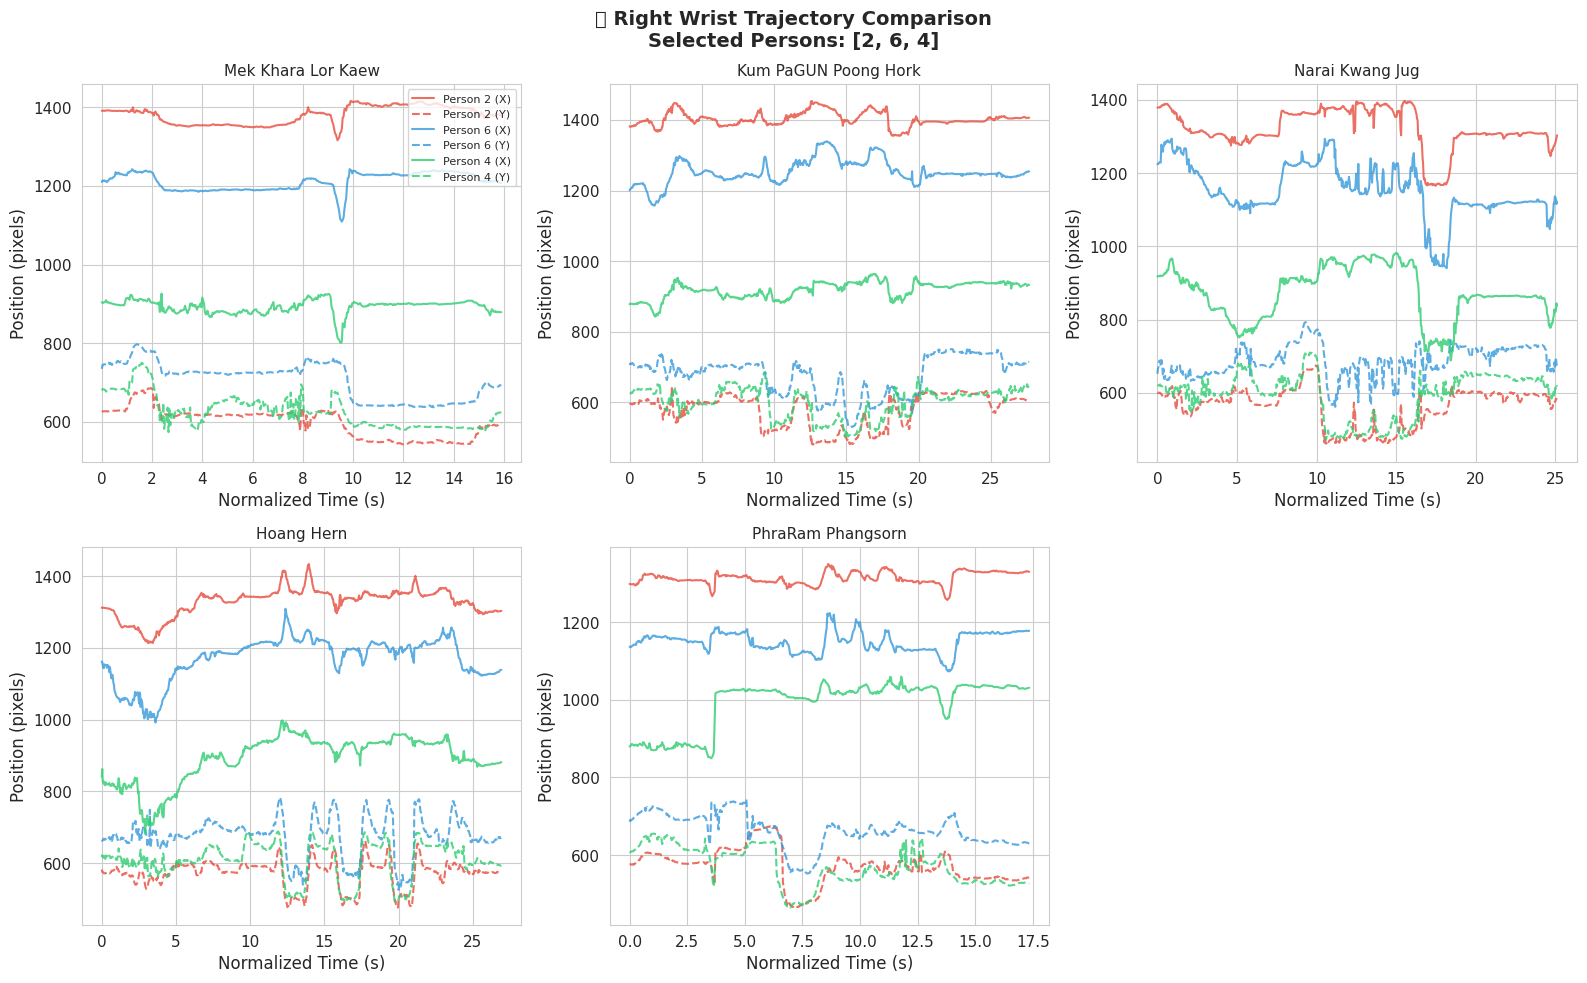


📊 Analyzing: Right Ankle


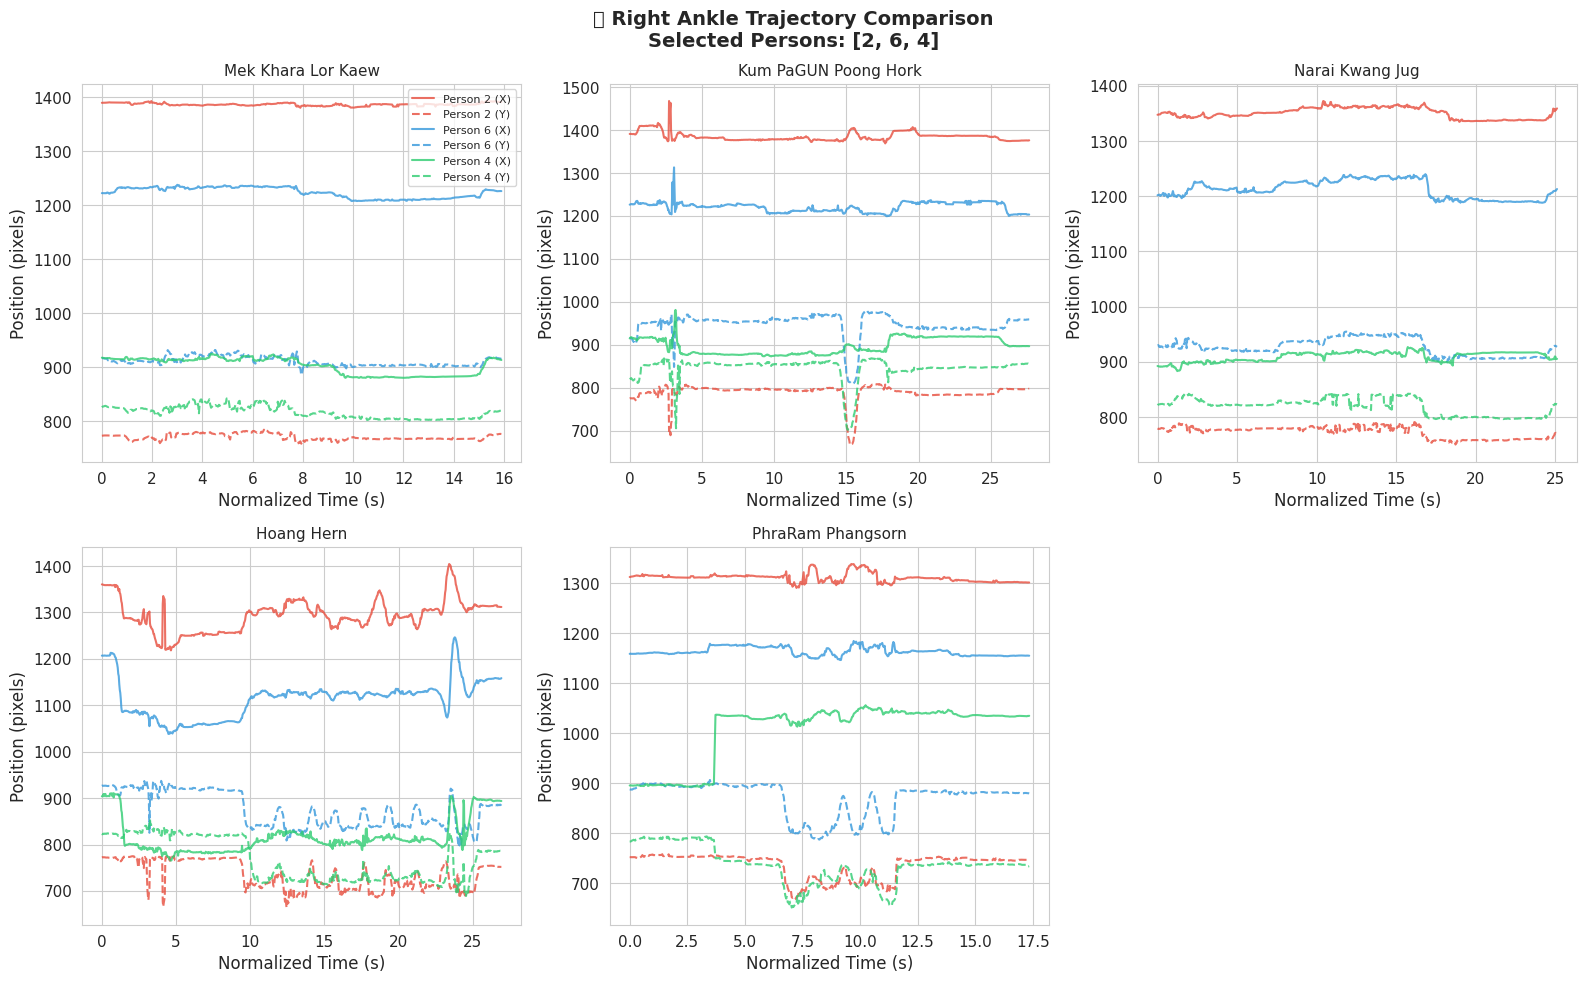

In [33]:
# =====================================================
# STEP 3.2: Compare Keypoint Trajectories Across Actions
# =====================================================
# 📝 Description: 
# เปรียบเทียบการเคลื่อนที่ของ keypoints
# ในแต่ละ action เพื่อหา pattern ที่แตกต่างกัน
#
# 🔍 What to look for:
# - รูปแบบการเคลื่อนไหวที่ซ้ำๆ (repetitive patterns)
# - ความแตกต่างระหว่าง actions
# - ความคล้ายคลึงระหว่าง persons ทำท่าเดียวกัน
# =====================================================

def plot_action_comparison(df, person_ids, keypoint, figsize=(16, 10)):
    """
    เปรียบเทียบ trajectory ของ keypoint ในแต่ละ action
    สำหรับ selected persons
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose
    person_ids : list - รายการ person IDs
    keypoint : str - ชื่อ keypoint
    figsize : tuple - ขนาดรูป
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # กรองข้อมูล
    df_selected = df[df['person_id'].isin(person_ids)].copy()
    actions = [a for a in df_selected['action'].unique() if a != 'Unknown']
    
    # สร้าง figure
    n_actions = len(actions)
    n_cols = 3
    n_rows = (n_actions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    fig.suptitle(f'🎯 {keypoint.replace("_", " ").title()} Trajectory Comparison\n'
                 f'Selected Persons: {person_ids}', 
                 fontsize=14, fontweight='bold')
    
    # Color map สำหรับ persons
    person_colors = dict(zip(person_ids, ['#e74c3c', '#3498db', '#2ecc71']))
    
    for idx, action in enumerate(actions):
        ax = axes[idx]
        action_data = df_selected[df_selected['action'] == action]
        
        for pid in person_ids:
            person_data = action_data[action_data['person_id'] == pid]
            if len(person_data) > 0:
                # Normalize time to start from 0
                person_data = person_data.sort_values('timestamp')
                time_normalized = person_data['timestamp'] - person_data['timestamp'].min()
                
                ax.plot(time_normalized, person_data[f'{keypoint}_x'], 
                       label=f'Person {pid} (X)', linestyle='-', alpha=0.8,
                       color=person_colors[pid])
                ax.plot(time_normalized, person_data[f'{keypoint}_y'], 
                       label=f'Person {pid} (Y)', linestyle='--', alpha=0.8,
                       color=person_colors[pid])
        
        ax.set_title(action.replace('_', ' '), fontsize=11)
        ax.set_xlabel('Normalized Time (s)')
        ax.set_ylabel('Position (pixels)')
        
        if idx == 0:
            ax.legend(fontsize=8, loc='upper right')
    
    # ซ่อน axes ที่ไม่ใช้
    for idx in range(len(actions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

# สร้างกราฟเปรียบเทียบสำหรับ right_wrist (สำคัญสำหรับหมัด)
print("=" * 70)
print("📊 ACTION TRAJECTORY COMPARISON")
print("=" * 70)
print("\n💡 Reading Guide:")
print("   ─── เส้นทึบ: X coordinate (ซ้าย-ขวา)")
print("   --- เส้นประ: Y coordinate (บน-ล่าง)")
print("   🔴 แดง: Person 1")
print("   🔵 น้ำเงิน: Person 2") 
print("   🟢 เขียว: Person 3")
print("\n" + "-" * 70)

for kpt in ['right_wrist', 'right_ankle']:
    print(f"\n📊 Analyzing: {kpt.replace('_', ' ').title()}")
    fig = plot_action_comparison(df_labeled, SELECTED_PERSON_IDS, kpt)
    plt.show()

### 3.3 Velocity Analysis

**อธิบาย:** วิเคราะห์ความเร็วของ Keypoints เพื่อหา pattern การเคลื่อนไหวที่รวดเร็ว

**สูตรคำนวณความเร็ว:**
```
velocity = √((dx/dt)² + (dy/dt)²)

โดยที่:
- dx = การเปลี่ยนแปลงตำแหน่ง X
- dy = การเปลี่ยนแปลงตำแหน่ง Y  
- dt = การเปลี่ยนแปลงเวลา
```

**การตีความ:**
- **ความเร็วสูง** = การเคลื่อนไหวที่รวดเร็ว (หมัด, เตะ)
- **ความเร็วต่ำ** = การเคลื่อนไหวช้าๆ (ท่าตั้งรับ, การเตรียมตัว)

```
       High Velocity              Low Velocity
           ↗                          →
          /                           
         /                            
        ○ ─→ ───→ ────→              ○ → ○ → ○
       หมัด/เตะ                      ท่าตั้งรับ
```

⚡ VELOCITY ANALYSIS

💡 Interpretation:
   📈 Peak สูง = การเคลื่อนไหวเร็ว (หมัด/เตะ)
   📉 ค่าต่ำ = การเคลื่อนไหวช้า (เตรียมตัว/ตั้งรับ)

----------------------------------------------------------------------

📊 Velocity analysis for: Right Wrist


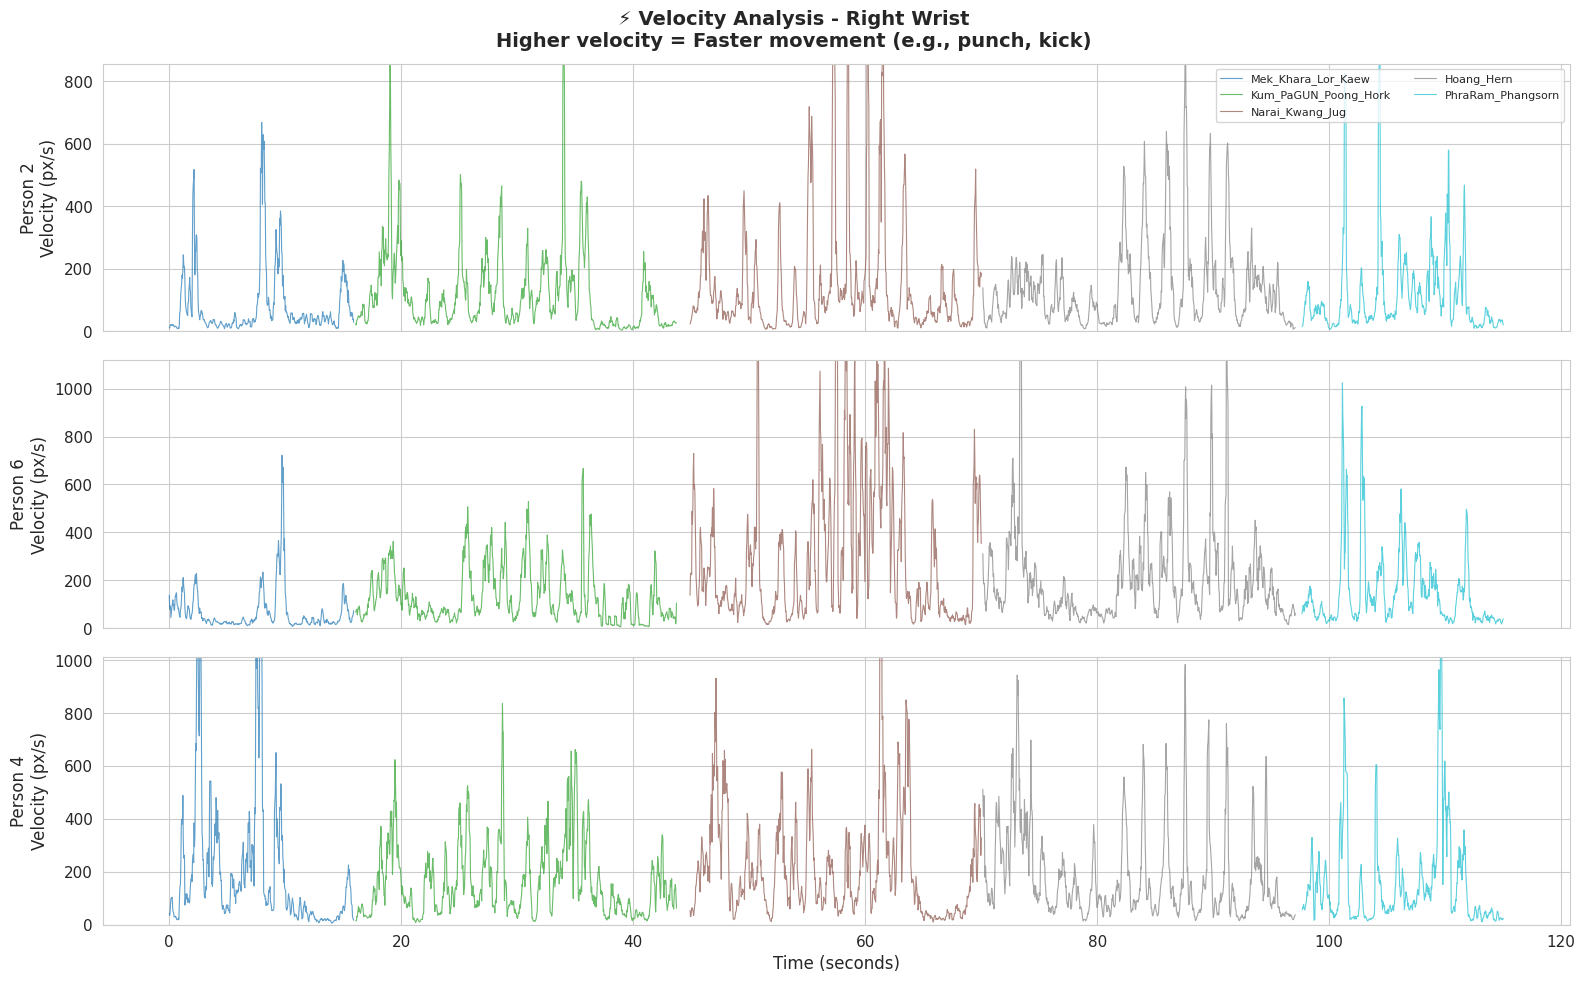


📊 Velocity analysis for: Left Wrist


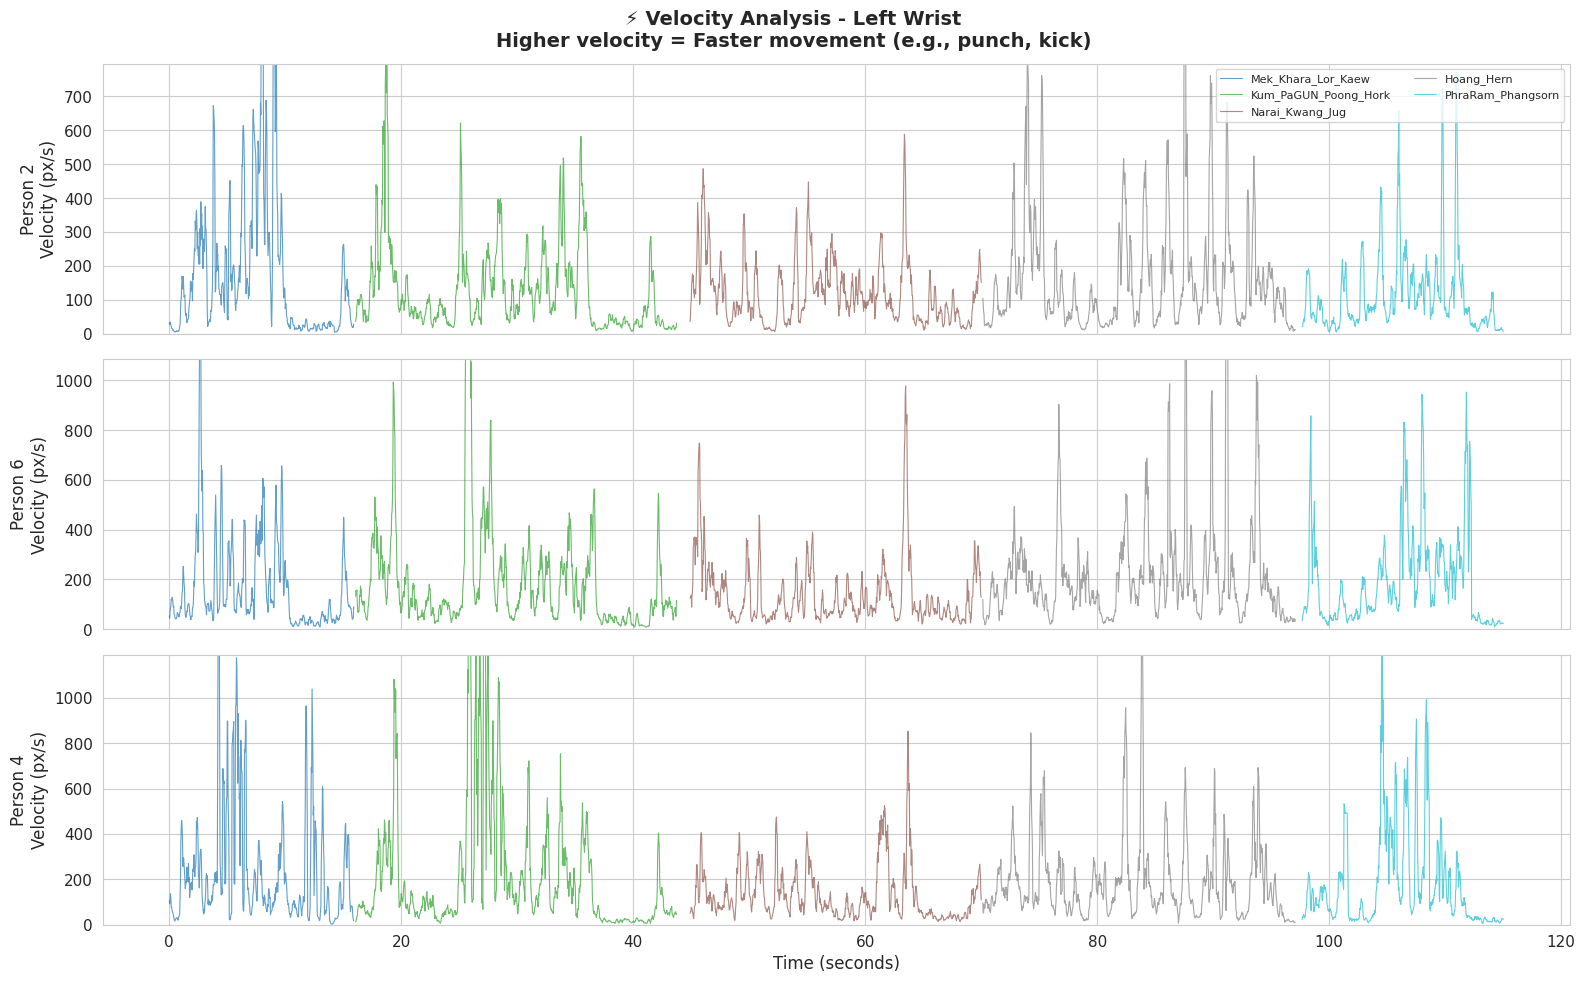

In [34]:
# =====================================================
# STEP 3.3: Velocity Analysis
# =====================================================
# 📝 Description: 
# คำนวณความเร็วของ keypoints
# ความเร็ว = การเปลี่ยนแปลงตำแหน่งต่อเวลา
# 
# 📐 Formula: 
# velocity = sqrt((dx/dt)^2 + (dy/dt)^2)
# 
# 🎯 Interpretation:
# - ความเร็วสูง = การเคลื่อนไหวที่รวดเร็ว (หมัด, เตะ)
# - ความเร็วต่ำ = การเคลื่อนไหวช้าๆ (ท่าตั้งรับ)
#
# 🔧 Smoothing:
# ใช้ uniform_filter1d เพื่อลด noise ในข้อมูล velocity
# =====================================================

def calculate_velocity(df, person_id, keypoint, window_size=3):
    """
    คำนวณความเร็วของ keypoint
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose
    person_id : int - Person ID
    keypoint : str - ชื่อ keypoint
    window_size : int - ขนาด window สำหรับ smoothing
    
    Returns:
    --------
    DataFrame พร้อมคอลัมน์ velocity และ velocity_smooth
    """
    # กรองและ sort ข้อมูล
    person_data = df[df['person_id'] == person_id].copy()
    person_data = person_data.sort_values('timestamp').reset_index(drop=True)
    
    # คำนวณ dx, dy, dt
    person_data['dx'] = person_data[f'{keypoint}_x'].diff()
    person_data['dy'] = person_data[f'{keypoint}_y'].diff()
    person_data['dt'] = person_data['timestamp'].diff()
    
    # คำนวณ velocity (Euclidean distance per time)
    person_data['velocity'] = np.sqrt(
        (person_data['dx'] / person_data['dt'])**2 + 
        (person_data['dy'] / person_data['dt'])**2
    )
    
    # Smooth velocity ด้วย moving average
    if window_size > 1 and len(person_data) > window_size:
        person_data['velocity_smooth'] = uniform_filter1d(
            person_data['velocity'].fillna(0), size=window_size
        )
    else:
        person_data['velocity_smooth'] = person_data['velocity']
    
    return person_data

def plot_velocity_analysis(df, person_ids, keypoint, figsize=(16, 10)):
    """
    สร้างกราฟวิเคราะห์ความเร็วเปรียบเทียบระหว่าง actions
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose
    person_ids : list - รายการ person IDs
    keypoint : str - ชื่อ keypoint
    figsize : tuple - ขนาดรูป
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    actions = [a for a in df['action'].unique() if a != 'Unknown']
    
    fig, axes = plt.subplots(len(person_ids), 1, figsize=figsize, sharex=True)
    if len(person_ids) == 1:
        axes = [axes]
    
    fig.suptitle(f'⚡ Velocity Analysis - {keypoint.replace("_", " ").title()}\n'
                 f'Higher velocity = Faster movement (e.g., punch, kick)', 
                 fontsize=14, fontweight='bold')
    
    # Color map สำหรับ actions
    action_colors = dict(zip(actions, plt.cm.tab10(np.linspace(0, 1, len(actions)))))
    
    for idx, pid in enumerate(person_ids):
        ax = axes[idx]
        
        # คำนวณ velocity
        vel_data = calculate_velocity(df, pid, keypoint, window_size=5)
        vel_data = vel_data[vel_data['action'] != 'Unknown']
        
        # Plot velocity for each action
        for action in actions:
            action_data = vel_data[vel_data['action'] == action]
            if len(action_data) > 0:
                ax.plot(action_data['timestamp'], action_data['velocity_smooth'],
                       label=action, alpha=0.7, linewidth=0.8,
                       color=action_colors[action])
        
        ax.set_ylabel(f'Person {pid}\nVelocity (px/s)')
        ax.set_ylim(0, vel_data['velocity_smooth'].quantile(0.99) * 1.1)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8, ncol=2)
    
    axes[-1].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    return fig

# วิเคราะห์ความเร็วสำหรับ wrists
print("=" * 70)
print("⚡ VELOCITY ANALYSIS")
print("=" * 70)
print("\n💡 Interpretation:")
print("   📈 Peak สูง = การเคลื่อนไหวเร็ว (หมัด/เตะ)")
print("   📉 ค่าต่ำ = การเคลื่อนไหวช้า (เตรียมตัว/ตั้งรับ)")
print("\n" + "-" * 70)

for kpt in ['right_wrist', 'left_wrist']:
    print(f"\n📊 Velocity analysis for: {kpt.replace('_', ' ').title()}")
    fig = plot_velocity_analysis(df_labeled, SELECTED_PERSON_IDS, kpt)
    plt.show()

### 3.4 Velocity Statistics per Action

**อธิบาย:** สรุปสถิติความเร็วเฉลี่ยของแต่ละ Action เพื่อจัดอันดับท่าที่เคลื่อนไหวเร็วที่สุด

**สถิติที่คำนวณ:**
- **Mean Velocity**: ความเร็วเฉลี่ย - บอกความเร็วโดยทั่วไปของท่า
- **Max Velocity**: ความเร็วสูงสุด - บอกความเร็วในจังหวะที่เร็วที่สุด
- **Std Velocity**: ค่าเบี่ยงเบนมาตรฐาน - บอกความแปรปรวนของการเคลื่อนไหว

📊 VELOCITY STATISTICS BY ACTION

📋 Average Velocity Statistics by Action:
   (Averaged across all persons and keypoints)

                      mean_velocity  max_velocity  std_velocity
action                                                         
Hoang_Hern                   140.21       1263.52        158.14
Narai_Kwang_Jug              119.17        876.26        126.36
Mek_Khara_Lor_Kaew           118.02        879.40        144.15
Kum_PaGUN_Poong_Hork         117.37       1546.58        170.35
PhraRam_Phangsorn            100.65        695.51        113.17

💡 Interpretation:
   🥇 Actions ที่อยู่ด้านบน = เคลื่อนไหวเร็วกว่า (หมัด/เตะ)
   🥉 Actions ที่อยู่ด้านล่าง = เคลื่อนไหวช้ากว่า (ตั้งรับ)


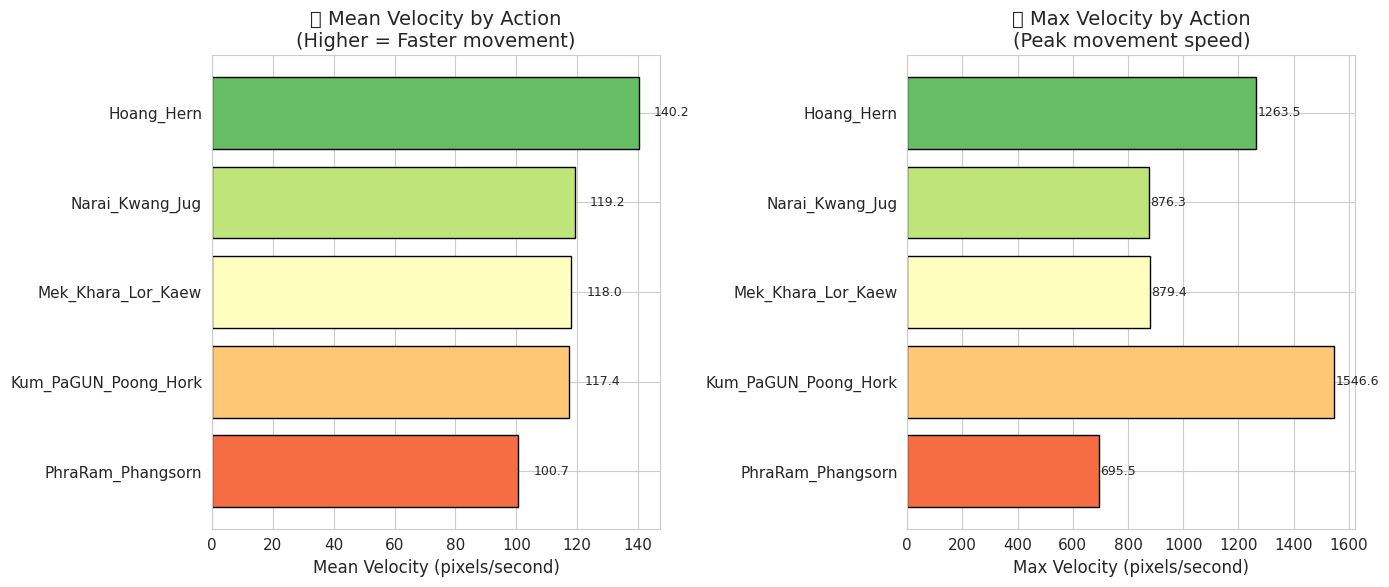

In [35]:
# =====================================================
# STEP 3.4: Velocity Statistics per Action
# =====================================================
# 📝 Description: 
# คำนวณและเปรียบเทียบสถิติความเร็ว
# ของแต่ละ action เพื่อระบุท่าที่เคลื่อนไหวเร็ว/ช้า
#
# 📊 Statistics computed:
# - Mean Velocity: ความเร็วเฉลี่ย
# - Max Velocity: ความเร็วสูงสุด
# - Std Velocity: ค่าเบี่ยงเบนมาตรฐาน
# - Median Velocity: ค่ามัธยฐาน
# =====================================================

def calculate_action_velocity_stats(df, person_ids, keypoints):
    """
    คำนวณสถิติความเร็วต่อ action
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose
    person_ids : list - รายการ person IDs
    keypoints : list - รายการ keypoints
    
    Returns:
    --------
    DataFrame ของสถิติความเร็ว
    """
    results = []
    
    for pid in person_ids:
        for kpt in keypoints:
            vel_data = calculate_velocity(df, pid, kpt, window_size=5)
            vel_data = vel_data[vel_data['action'] != 'Unknown']
            
            # คำนวณสถิติต่อ action
            for action in vel_data['action'].unique():
                action_data = vel_data[vel_data['action'] == action]['velocity_smooth']
                action_data = action_data.dropna()
                
                if len(action_data) > 0:
                    results.append({
                        'person_id': pid,
                        'keypoint': kpt,
                        'action': action,
                        'mean_velocity': action_data.mean(),
                        'max_velocity': action_data.max(),
                        'std_velocity': action_data.std(),
                        'median_velocity': action_data.median()
                    })
    
    return pd.DataFrame(results)

# คำนวณสถิติ
velocity_stats = calculate_action_velocity_stats(
    df_labeled, 
    SELECTED_PERSON_IDS, 
    ['right_wrist', 'left_wrist', 'right_ankle', 'left_ankle']
)

print("=" * 70)
print("📊 VELOCITY STATISTICS BY ACTION")
print("=" * 70)

# เฉลี่ยข้าม persons และ keypoints
action_velocity_summary = velocity_stats.groupby('action').agg({
    'mean_velocity': 'mean',
    'max_velocity': 'mean',
    'std_velocity': 'mean'
}).round(2)

action_velocity_summary = action_velocity_summary.sort_values('mean_velocity', ascending=False)

print("\n📋 Average Velocity Statistics by Action:")
print("   (Averaged across all persons and keypoints)")
print("\n" + action_velocity_summary.to_string())

print("\n💡 Interpretation:")
print("   🥇 Actions ที่อยู่ด้านบน = เคลื่อนไหวเร็วกว่า (หมัด/เตะ)")
print("   🥉 Actions ที่อยู่ด้านล่าง = เคลื่อนไหวช้ากว่า (ตั้งรับ)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mean velocity by action
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(action_velocity_summary)))[::-1]
bars = axes[0].barh(action_velocity_summary.index, 
                    action_velocity_summary['mean_velocity'],
                    color=colors, edgecolor='black')
axes[0].set_xlabel('Mean Velocity (pixels/second)')
axes[0].set_title('📊 Mean Velocity by Action\n(Higher = Faster movement)')
axes[0].invert_yaxis()

# เพิ่มค่าบน bar
for bar, val in zip(bars, action_velocity_summary['mean_velocity']):
    axes[0].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}', va='center', fontsize=9)

# Max velocity by action
bars = axes[1].barh(action_velocity_summary.index, 
                    action_velocity_summary['max_velocity'],
                    color=colors, edgecolor='black')
axes[1].set_xlabel('Max Velocity (pixels/second)')
axes[1].set_title('📊 Max Velocity by Action\n(Peak movement speed)')
axes[1].invert_yaxis()

# เพิ่มค่าบน bar
for bar, val in zip(bars, action_velocity_summary['max_velocity']):
    axes[1].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---

## 📚 Part 4: Joint Angle Analysis

ในส่วนนี้เราจะคำนวณและวิเคราะห์มุมข้อต่อ (Joint Angles) ซึ่งเป็นตัวแปรสำคัญในการวิเคราะห์ท่าทาง

### 4.1 Understanding Joint Angles

**Joint Angle คืออะไร?**
- มุมที่เกิดจากข้อต่อ 3 จุด (เช่น ไหล่-ข้อศอก-ข้อมือ)
- ใช้ในการวิเคราะห์ท่าทางและการเคลื่อนไหว
- สำคัญมากในกีฬาและการวิเคราะห์การเคลื่อนไหว

**Angles ที่จะคำนวณ:**

| Angle | Points | ความหมาย |
|-------|--------|----------|
| Elbow Angle | shoulder-elbow-wrist | มุมงอข้อศอก |
| Knee Angle | hip-knee-ankle | มุมงอเข่า |
| Shoulder Angle | elbow-shoulder-hip | มุมยกแขน |
| Hip Angle | shoulder-hip-knee | มุมยกขา |
| Torso Lean | จากแนวตั้ง | มุมเอียงลำตัว |

**ภาพประกอบการคำนวณมุม:**
```
        p1 (shoulder)
         \
          \  ← angle
           \
            p2 (elbow) ────── p3 (wrist)

angle = arctan2(|cross(v1,v2)|, dot(v1,v2))
โดย v1 = p1 - p2, v2 = p3 - p2
```

**ตัวอย่างค่ามุม:**
```
Elbow Angle:
- 180° = แขนเหยียดตรง
- 90°  = งอ 90 องศา
- 45°  = งอมาก

  180°           90°            45°
  ────○         ○              ○
      │          \            /
      │           \          /
      ○            ○        ○
```

In [36]:
# =====================================================
# STEP 4.1: Joint Angle Calculation Functions
# =====================================================
# 📝 Description: 
# สร้างฟังก์ชันคำนวณมุมข้อต่อ
# 
# 📐 Mathematical Principle:
# ใช้ dot product และ cross product
# angle = atan2(|cross_product|, dot_product)
# 
# 📊 Output:
# มุมเป็นองศา (degrees) ตั้งแต่ 0° ถึง 180°
#
# 💡 Note:
# - 180° = เหยียดตรง
# - 90° = งอฉาก
# - 0° = พับชิด
# =====================================================

def calculate_angle(p1, p2, p3):
    """
    คำนวณมุมที่จุด p2 จากเส้น p1-p2 และ p2-p3
    
    Parameters:
    -----------
    p1, p2, p3 : np.array - พิกัด (x, y) ของแต่ละจุด
    
    Returns:
    --------
    angle : float - มุมเป็นองศา (0-180)
    
    Diagram:
           p1
            \
             \  angle
              p2-------p3
    
    Formula:
    angle = arctan2(|v1 × v2|, v1 · v2)
    """
    # Vector จาก p2 ไป p1 และ p3
    v1 = p1 - p2
    v2 = p3 - p2
    
    # ตรวจสอบว่ามีค่า valid หรือไม่ (0 = keypoint not detected)
    if np.any(p1 == 0) or np.any(p2 == 0) or np.any(p3 == 0):
        return np.nan
    
    # คำนวณ dot product: v1 · v2 = |v1||v2|cos(θ)
    dot = np.dot(v1, v2)
    
    # คำนวณ cross product magnitude: |v1 × v2| = |v1||v2|sin(θ)
    cross = np.cross(v1, v2)
    
    # คำนวณมุม (radians) ด้วย atan2 เพื่อได้มุมที่ถูกต้องในทุก quadrant
    angle_rad = np.arctan2(np.abs(cross), dot)
    
    # แปลงเป็น degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def calculate_all_angles(row):
    """
    คำนวณมุมข้อต่อทั้งหมดสำหรับ 1 row ของข้อมูล
    
    Parameters:
    -----------
    row : pandas Series - 1 row ของ DataFrame
    
    Returns:
    --------
    dict : dictionary ของมุมต่างๆ
    """
    angles = {}
    
    # Helper function ดึงพิกัด keypoint
    def get_point(name):
        return np.array([row[f'{name}_x'], row[f'{name}_y']])
    
    # ===== Elbow Angles (มุมข้อศอก) =====
    # การงอข้อศอก: shoulder-elbow-wrist
    angles['left_elbow_angle'] = calculate_angle(
        get_point('left_shoulder'),
        get_point('left_elbow'),
        get_point('left_wrist')
    )
    
    angles['right_elbow_angle'] = calculate_angle(
        get_point('right_shoulder'),
        get_point('right_elbow'),
        get_point('right_wrist')
    )
    
    # ===== Knee Angles (มุมเข่า) =====
    # การงอเข่า: hip-knee-ankle
    angles['left_knee_angle'] = calculate_angle(
        get_point('left_hip'),
        get_point('left_knee'),
        get_point('left_ankle')
    )
    
    angles['right_knee_angle'] = calculate_angle(
        get_point('right_hip'),
        get_point('right_knee'),
        get_point('right_ankle')
    )
    
    # ===== Shoulder Angles (มุมไหล่) =====
    # การยกแขน: elbow-shoulder-hip
    angles['left_shoulder_angle'] = calculate_angle(
        get_point('left_elbow'),
        get_point('left_shoulder'),
        get_point('left_hip')
    )
    
    angles['right_shoulder_angle'] = calculate_angle(
        get_point('right_elbow'),
        get_point('right_shoulder'),
        get_point('right_hip')
    )
    
    # ===== Hip Angles (มุมสะโพก) =====
    # การยกขา: shoulder-hip-knee
    angles['left_hip_angle'] = calculate_angle(
        get_point('left_shoulder'),
        get_point('left_hip'),
        get_point('left_knee')
    )
    
    angles['right_hip_angle'] = calculate_angle(
        get_point('right_shoulder'),
        get_point('right_hip'),
        get_point('right_knee')
    )
    
    # ===== Torso Lean Angle (มุมเอียงลำตัว) =====
    # คำนวณจากเส้นที่เชื่อม shoulder center กับ hip center
    shoulder_mid = (get_point('left_shoulder') + get_point('right_shoulder')) / 2
    hip_mid = (get_point('left_hip') + get_point('right_hip')) / 2
    
    # มุมของลำตัวเทียบกับแนวตั้ง (vertical)
    vertical = np.array([0, -1])  # ขึ้นบน (ใน pixel coord, Y ลดลง = ขึ้นบน)
    torso_vector = shoulder_mid - hip_mid
    
    if np.linalg.norm(torso_vector) > 0:
        torso_vector_norm = torso_vector / np.linalg.norm(torso_vector)
        dot = np.dot(torso_vector_norm, vertical)
        angles['torso_lean_angle'] = np.degrees(np.arccos(np.clip(dot, -1, 1)))
    else:
        angles['torso_lean_angle'] = np.nan
    
    return angles

print("✅ Angle calculation functions defined!")
print("\n📐 Angles to be calculated:")
print("   ┌────────────────────────────────────────────┐")
print("   │ Angle Name          │ Points               │")
print("   ├────────────────────────────────────────────┤")
print("   │ Elbow Angle         │ shoulder-elbow-wrist │")
print("   │ Knee Angle          │ hip-knee-ankle       │")
print("   │ Shoulder Angle      │ elbow-shoulder-hip   │")
print("   │ Hip Angle           │ shoulder-hip-knee    │")
print("   │ Torso Lean          │ from vertical        │")
print("   └────────────────────────────────────────────┘")

✅ Angle calculation functions defined!

📐 Angles to be calculated:
   ┌────────────────────────────────────────────┐
   │ Angle Name          │ Points               │
   ├────────────────────────────────────────────┤
   │ Elbow Angle         │ shoulder-elbow-wrist │
   │ Knee Angle          │ hip-knee-ankle       │
   │ Shoulder Angle      │ elbow-shoulder-hip   │
   │ Hip Angle           │ shoulder-hip-knee    │
   │ Torso Lean          │ from vertical        │
   └────────────────────────────────────────────┘


### 4.2 Calculate Angles for All Data

**อธิบาย:** คำนวณมุมข้อต่อทั้งหมดสำหรับทุก frame ในข้อมูล

**ขั้นตอน:**
1. ใช้ฟังก์ชัน `calculate_all_angles()` กับทุก row
2. เพิ่มคอลัมน์มุมเข้าไปใน DataFrame
3. ตรวจสอบผลลัพธ์

In [37]:
# =====================================================
# STEP 4.2: Calculate Angles for All Data
# =====================================================
# 📝 Description: 
# คำนวณมุมข้อต่อทั้งหมดสำหรับทุก frame
#
# ⏱️ Note: 
# การคำนวณนี้อาจใช้เวลาสักครู่ (30 วินาที - 2 นาที)
# ขึ้นอยู่กับจำนวนข้อมูล
#
# 🔄 Process:
# 1. Apply calculate_all_angles() to each row
# 2. Convert results to DataFrame
# 3. Merge with original data
# =====================================================

print("=" * 70)
print("📐 CALCULATING JOINT ANGLES")
print("=" * 70)
print(f"\n⏳ Processing {len(df_labeled):,} frames... This may take a moment.")

# คำนวณมุมทั้งหมด
import time
start_time = time.time()

# Apply function to each row และแปลงเป็น DataFrame
angles_list = df_labeled.apply(calculate_all_angles, axis=1).tolist()
angles_df = pd.DataFrame(angles_list)

# รวมกับข้อมูลเดิม
df_with_angles = pd.concat([df_labeled.reset_index(drop=True), angles_df], axis=1)

elapsed_time = time.time() - start_time
print(f"✅ Calculation completed in {elapsed_time:.2f} seconds")

# แสดงรายชื่อ angle columns
angle_columns = [col for col in df_with_angles.columns if '_angle' in col]
print(f"\n📊 Angle columns added: {len(angle_columns)}")
for col in angle_columns:
    print(f"   - {col}")

# แสดงตัวอย่างข้อมูล
print("\n" + "=" * 70)
print("📋 SAMPLE DATA WITH ANGLES")
print("=" * 70)
display(df_with_angles[['frame_idx', 'person_id', 'action'] + angle_columns].head(10))

# แสดงสถิติเบื้องต้นของมุม
print("\n" + "=" * 70)
print("📊 ANGLE STATISTICS SUMMARY")
print("=" * 70)
print(df_with_angles[angle_columns].describe().round(2))

📐 CALCULATING JOINT ANGLES

⏳ Processing 29,602 frames... This may take a moment.
✅ Calculation completed in 5.10 seconds

📊 Angle columns added: 9
   - left_elbow_angle
   - right_elbow_angle
   - left_knee_angle
   - right_knee_angle
   - left_shoulder_angle
   - right_shoulder_angle
   - left_hip_angle
   - right_hip_angle
   - torso_lean_angle

📋 SAMPLE DATA WITH ANGLES


frame_idx  person_id              action  left_elbow_angle  \
0          0          1  Mek_Khara_Lor_Kaew         59.771196   
1          0          2  Mek_Khara_Lor_Kaew         85.122118   
2          0          3  Mek_Khara_Lor_Kaew         93.120364   
3          0          4  Mek_Khara_Lor_Kaew        112.388152   
4          0          5  Mek_Khara_Lor_Kaew        114.363403   
5          0          6  Mek_Khara_Lor_Kaew         97.176567   
6          0          7  Mek_Khara_Lor_Kaew        107.365636   
7          0          8  Mek_Khara_Lor_Kaew        146.737837   
8          0          9  Mek_Khara_Lor_Kaew        116.898337   
9          1          1  Mek_Khara_Lor_Kaew         60.277088   

   right_elbow_angle  left_knee_angle  right_knee_angle  left_shoulder_angle  \
0          29.293800       178.123217        173.335134            28.361431   
1         159.788235       177.492571        178.010358            54.108888   
2         151.685272       170.353137        179.887285            40.256154   
3         154.234435       173.467202        178.273912            39.622895   
4          78.512019       176.203548        174.478299            29.464956   
5         148.455528       165.216593        177.811654            44.471559   
6         144.933764       174.176651        175.911985            34.493828   
7          93.672663       174.321164        167.765374             4.440949   
8         147.103427       167.415383        176.833413            32.902186   
9          38.743249       176.779967        174.172146            27.762600   

   right_shoulder_angle  left_hip_angle  right_hip_angle  torso_lean_angle  
0             24.354715      168.487339       174.650843          6.101136  
1              8.401567      165.077871       176.652102          6.375660  
2              7.688624      170.425437       177.990146          5.140322  
3              8.168165      170.994122       175.991056          3.733424  
4             46.406829      175.676279       179.878654          1.195527  
5              5.136873      175.991715       178.125746          3.286882  
6             17.388609      168.914150       172.846918          4.185966  
7             45.971646      176.105718       177.744879          2.911281  
8             12.929691      169.967998       177.043229          5.396186  
9             23.877233      168.448535       176.023987          6.493681


📊 ANGLE STATISTICS SUMMARY
       left_elbow_angle  right_elbow_angle  left_knee_angle  right_knee_angle  \
count          29602.00           29602.00         29602.00          29602.00   
mean              89.46              88.89           155.40            152.32   
std               43.96              52.02            27.98             31.83   
min                0.01               0.00             1.72              6.47   
25%               56.12              43.26           148.00            145.41   
50%               86.67              88.41           165.85            166.08   
75%              122.04             136.57           174.73            174.34   
max              179.97             179.99           180.00            180.00   

       left_shoulder_angle  right_shoulder_angle  left_hip_angle  \
count             29602.00              29602.00        29602.00   
mean                 50.32                 61.04          156.52   
std                  46.38            

### 4.3 Angle Time Series Visualization

**อธิบาย:** แสดงการเปลี่ยนแปลงของมุมข้อต่อตามเวลา

**การอ่านกราฟ:**
- แกน Y: มุมเป็นองศา (0° - 180°)
- เส้นประสีเทา 90°: มุมฉาก (reference line)
- สีต่างกัน: actions ต่างกัน

**Pattern ที่ควรสังเกต:**
- **หมัดตรง**: elbow angle เพิ่มขึ้นอย่างรวดเร็ว (แขนเหยียด)
- **เตะ**: knee angle เพิ่มขึ้น + hip angle เปลี่ยน
- **ท่าตั้งรับ**: มุมค่อนข้างคงที่

📐 ANGLE TIME SERIES VISUALIZATION

💡 Reading Guide:
   - Y-axis: Angle (0° to 180°)
   - 180° = fully extended (straight)
   - 90° = right angle
   - 0° = fully flexed
   - Gray dashed line = 90° reference

----------------------------------------------------------------------

📊 Generating plot for Person ID: 2


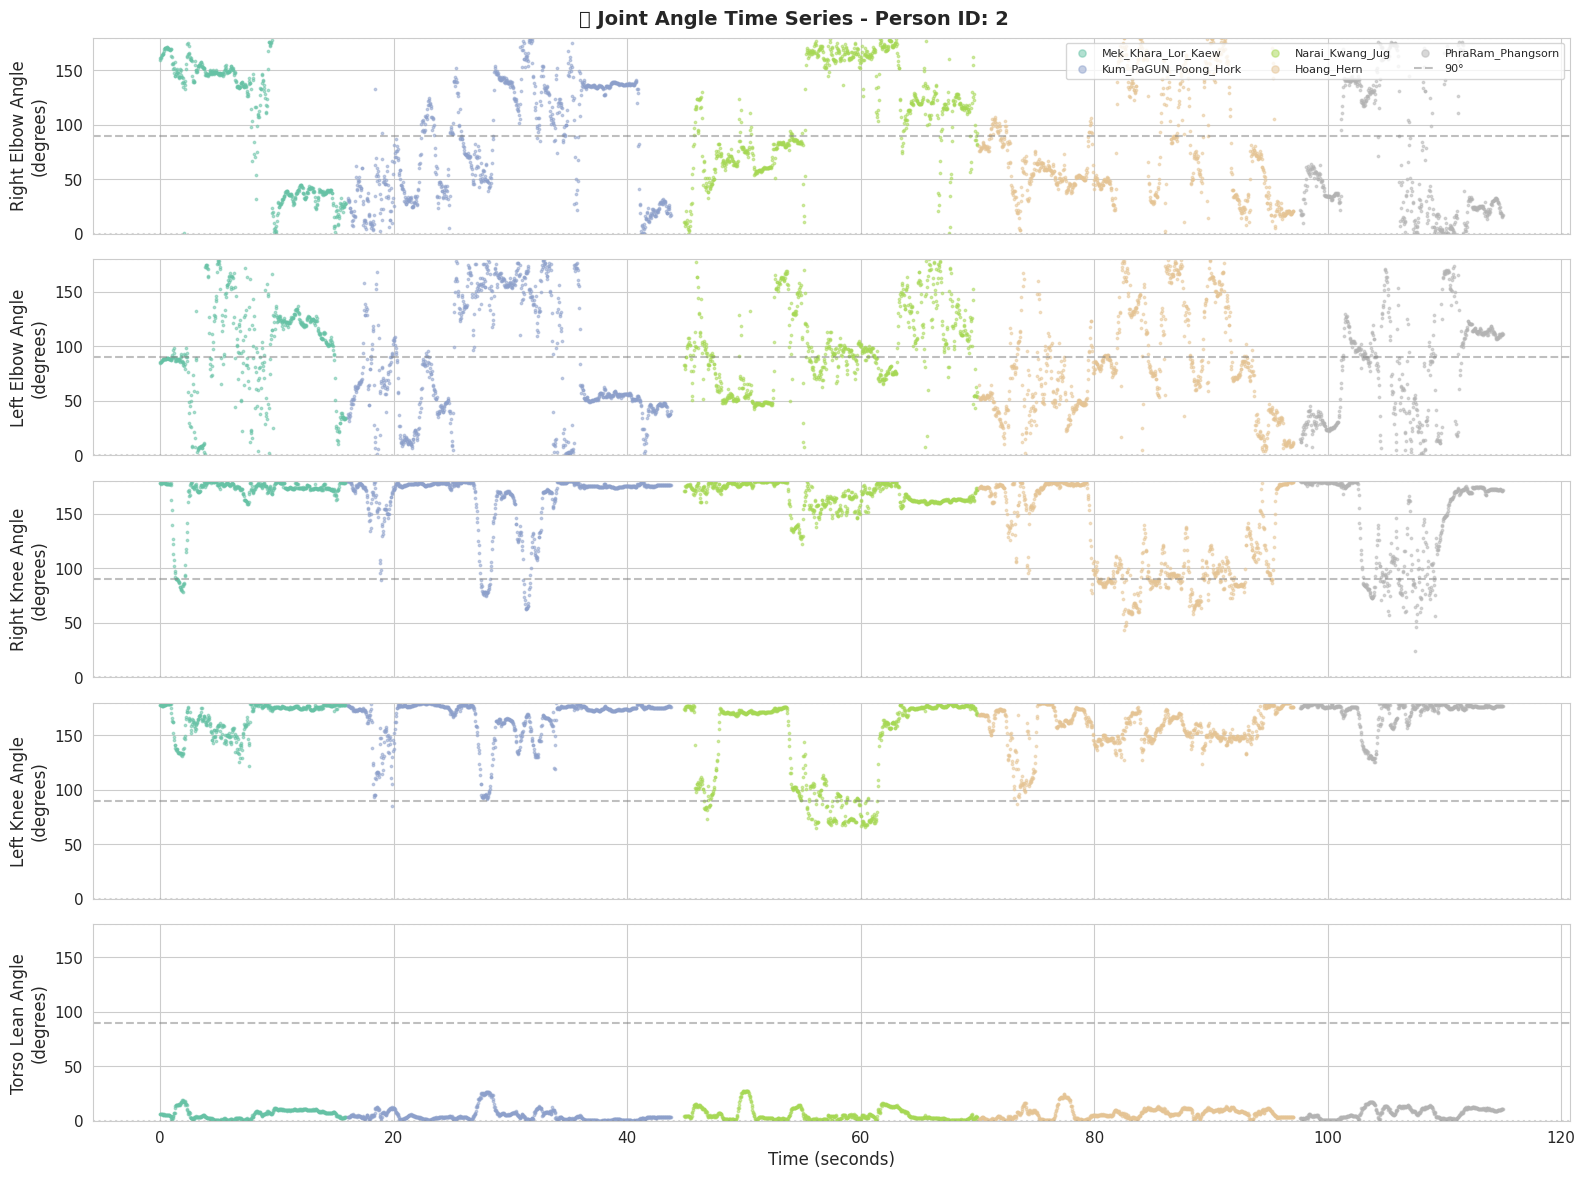


📊 Generating plot for Person ID: 6


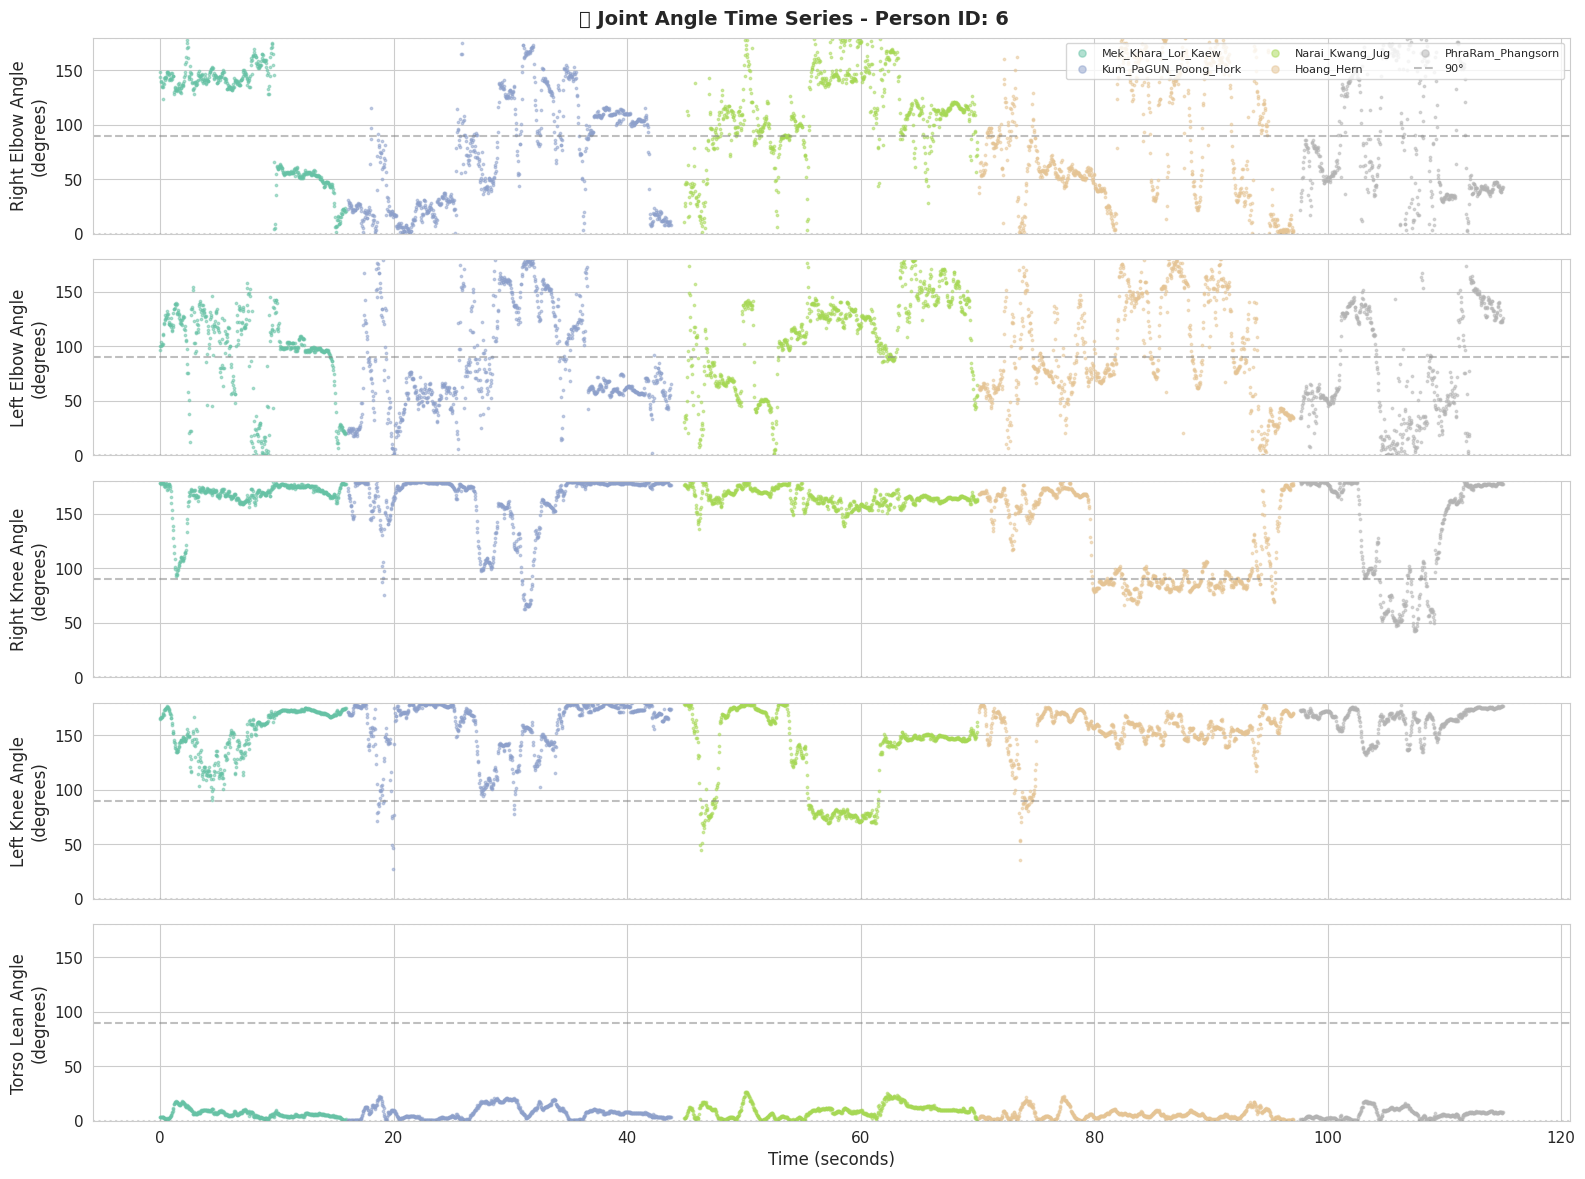


📊 Generating plot for Person ID: 4


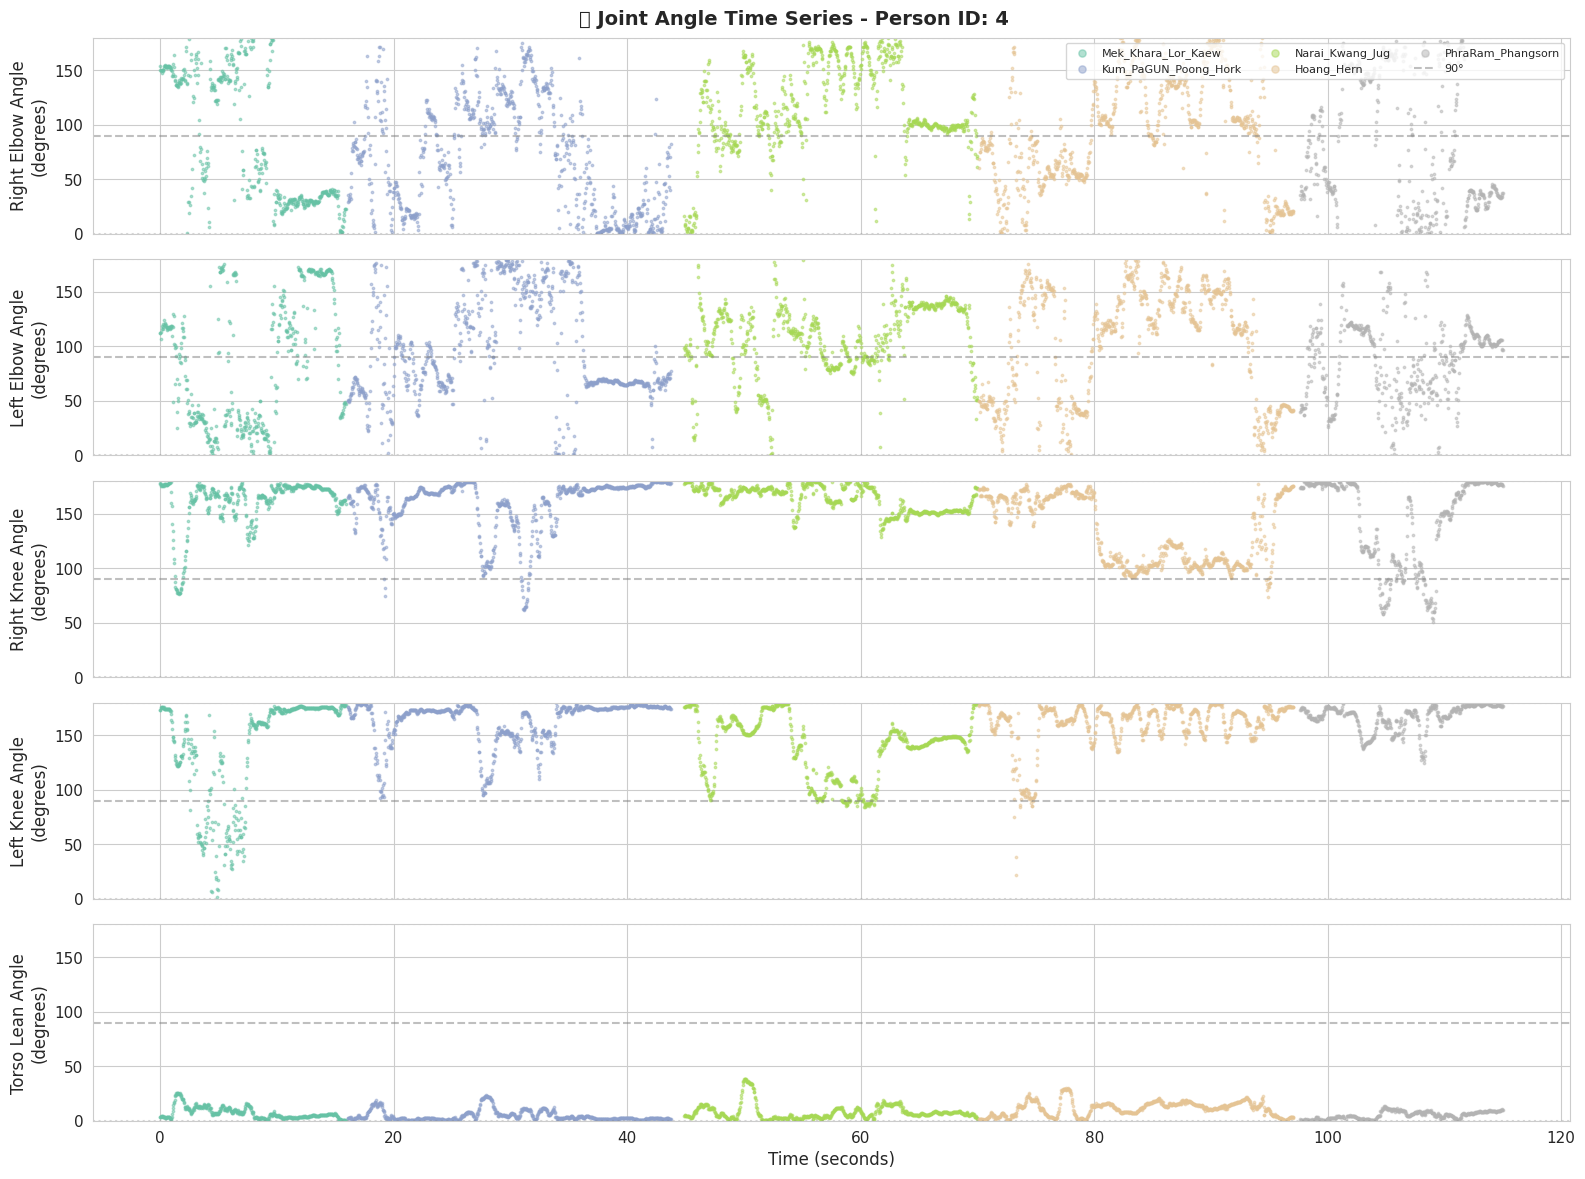

In [48]:
# =====================================================
# STEP 4.3: Angle Time Series Visualization
# =====================================================
# 📝 Description: 
# สร้างกราฟแสดงการเปลี่ยนแปลงของมุมข้อต่อ
# ตามเวลาสำหรับแต่ละ action
#
# 📊 Graph elements:
# - Y-axis: Angle in degrees (0° - 180°)
# - Gray dashed line at 90°: right angle reference
# - Different colors: different actions
#
# 💡 What to look for:
# - Rapid changes = fast movements
# - Stable values = static poses
# - Periodic patterns = repetitive movements
# =====================================================

def plot_angle_timeseries(df, person_id, angles, figsize=(16, 12)):
    """
    สร้างกราฟ Time Series ของมุมข้อต่อ
    
    Parameters:
    -----------
    df : DataFrame - ข้อมูล pose พร้อมมุม
    person_id : int - Person ID
    angles : list - รายชื่อ angle columns
    figsize : tuple - ขนาดรูป
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    person_data = df[df['person_id'] == person_id].copy()
    person_data = person_data.sort_values('timestamp')
    
    # สร้าง figure
    fig, axes = plt.subplots(len(angles), 1, figsize=figsize, sharex=True)
    if len(angles) == 1:
        axes = [axes]
    
    fig.suptitle(f'📐 Joint Angle Time Series - Person ID: {person_id}', 
                 fontsize=14, fontweight='bold')
    
    # Color map สำหรับ actions
    actions = [a for a in person_data['action'].unique() if a != 'Unknown']
    action_colors = dict(zip(actions, plt.cm.Set2(np.linspace(0, 1, len(actions)))))
    
    for idx, angle_name in enumerate(angles):
        ax = axes[idx]
        
        for action in actions:
            action_data = person_data[person_data['action'] == action]
            if len(action_data) > 0:
                ax.scatter(action_data['timestamp'], action_data[angle_name],
                          label=action, alpha=0.5, s=3, color=action_colors[action])
        
        # Format axis
        ax.set_ylabel(f'{angle_name.replace("_", " ").title()}\n(degrees)')
        ax.set_ylim(0, 180)
        
        # Reference lines
        ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90°' if idx == 0 else '')
        ax.axhline(y=180, color='gray', linestyle=':', alpha=0.3)
        ax.axhline(y=0, color='gray', linestyle=':', alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8, ncol=3, markerscale=3)
    
    axes[-1].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    return fig

# Angles ที่จะวิเคราะห์
ANALYSIS_ANGLES = ['right_elbow_angle', 'left_elbow_angle', 
                   'right_knee_angle', 'left_knee_angle',
                   'torso_lean_angle']

print("=" * 70)
print("📐 ANGLE TIME SERIES VISUALIZATION")
print("=" * 70)
print("\n💡 Reading Guide:")
print("   - Y-axis: Angle (0° to 180°)")
print("   - 180° = fully extended (straight)")
print("   - 90° = right angle")
print("   - 0° = fully flexed")
print("   - Gray dashed line = 90° reference")
print("\n" + "-" * 70)

for pid in SELECTED_PERSON_IDS[:3]:  # แสดงเฉพาะ person แรก
    print(f"\n📊 Generating plot for Person ID: {pid}")
    fig = plot_angle_timeseries(df_with_angles, pid, ANALYSIS_ANGLES)
    plt.show()

### 4.4 Angle Statistics per Action

**อธิบาย:** เปรียบเทียบค่าเฉลี่ยและการกระจายของมุมในแต่ละ Action

**Box Plot Interpretation:**
```
    ┬── Maximum (Q3 + 1.5*IQR)
    │
  ┌─┼─┐ ── Q3 (75th percentile)
  │ │ │
  │ ├─┤ ── Median (Q2, 50th percentile)
  │ │ │
  └─┼─┘ ── Q1 (25th percentile)
    │
    ┴── Minimum (Q1 - 1.5*IQR)
    
    ○ ── Outliers
```

📊 ANGLE STATISTICS BY ACTION

📋 Mean Angle by Action (degrees):
                      left_elbow_angle  right_elbow_angle  left_knee_angle  right_knee_angle  left_shoulder_angle  right_shoulder_angle  left_hip_angle  right_hip_angle  torso_lean_angle
action                                                                                                                                                                                    
Hoang_Hern                       88.11              83.29           158.09            132.14                37.93                 43.79          162.32           164.29              6.54
Kum_PaGUN_Poong_Hork             92.92              83.68           161.17            160.77                76.59                 71.80          164.92           163.63              4.36
Mek_Khara_Lor_Kaew               85.15              84.52           153.83            162.16                34.16                 52.78          158.05           168.20              5.43
N

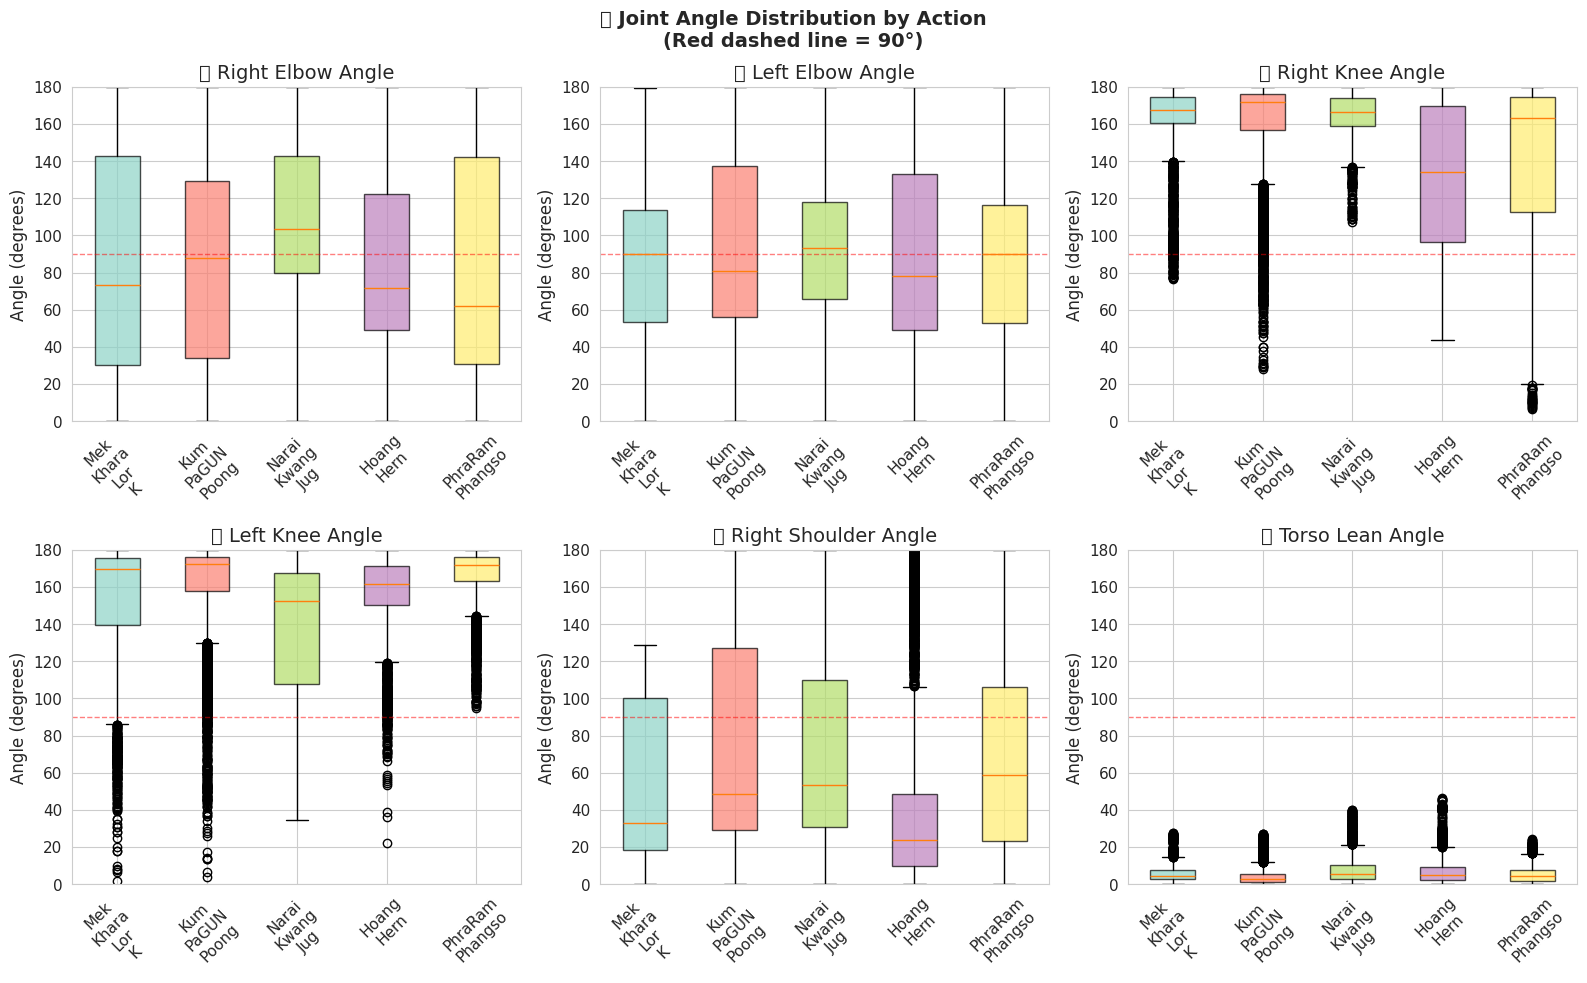

In [39]:
# =====================================================
# STEP 4.4: Angle Statistics per Action
# =====================================================
# 📝 Description: 
# คำนวณและเปรียบเทียบสถิติมุมของแต่ละ action
# เพื่อระบุลักษณะเฉพาะของแต่ละท่า
#
# 📊 Statistics:
# - Mean: ค่าเฉลี่ย
# - Std: ค่าเบี่ยงเบนมาตรฐาน
# - Min/Max: ค่าต่ำสุด/สูงสุด
#
# 📈 Visualization:
# Box plot แสดงการกระจายของมุมในแต่ละ action
# =====================================================

# คำนวณสถิติมุมต่อ action
angle_stats = df_with_angles.groupby('action')[angle_columns].agg(['mean', 'std', 'min', 'max'])
angle_stats = angle_stats.round(2)

print("=" * 70)
print("📊 ANGLE STATISTICS BY ACTION")
print("=" * 70)

# แสดงค่าเฉลี่ยมุม
print("\n📋 Mean Angle by Action (degrees):")
mean_angles = df_with_angles.groupby('action')[angle_columns].mean().round(2)
print(mean_angles.to_string())

# Visualization - Box plots for key angles
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

key_angles = ['right_elbow_angle', 'left_elbow_angle', 
              'right_knee_angle', 'left_knee_angle',
              'right_shoulder_angle', 'torso_lean_angle']

actions_list = [a for a in df_with_angles['action'].unique() if a != 'Unknown']

for idx, angle in enumerate(key_angles):
    ax = axes[idx]
    
    # สร้าง box plot
    data_for_plot = [df_with_angles[df_with_angles['action'] == action][angle].dropna() 
                     for action in actions_list]
    
    bp = ax.boxplot(data_for_plot, labels=[a.replace('_', '\n')[:15] for a in actions_list],
                    patch_artist=True)
    
    # สีสำหรับ box
    colors = plt.cm.Set3(np.linspace(0, 1, len(actions_list)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Angle (degrees)')
    ax.set_title(f'📐 {angle.replace("_", " ").title()}')
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=90, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_ylim(0, 180)

plt.suptitle('📊 Joint Angle Distribution by Action\n(Red dashed line = 90°)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5 Angle Heatmap Comparison

**อธิบาย:** สร้าง Heatmap เปรียบเทียบค่าเฉลี่ยมุมของแต่ละ Action

**การอ่าน Heatmap:**
- **สีแดงเข้ม**: มุมมาก (ใกล้ 180° = เหยียด)
- **สีน้ำเงินเข้ม**: มุมน้อย (ใกล้ 0° = งอ)
- **ตัวเลขในช่อง**: ค่าเฉลี่ยมุม (องศา)

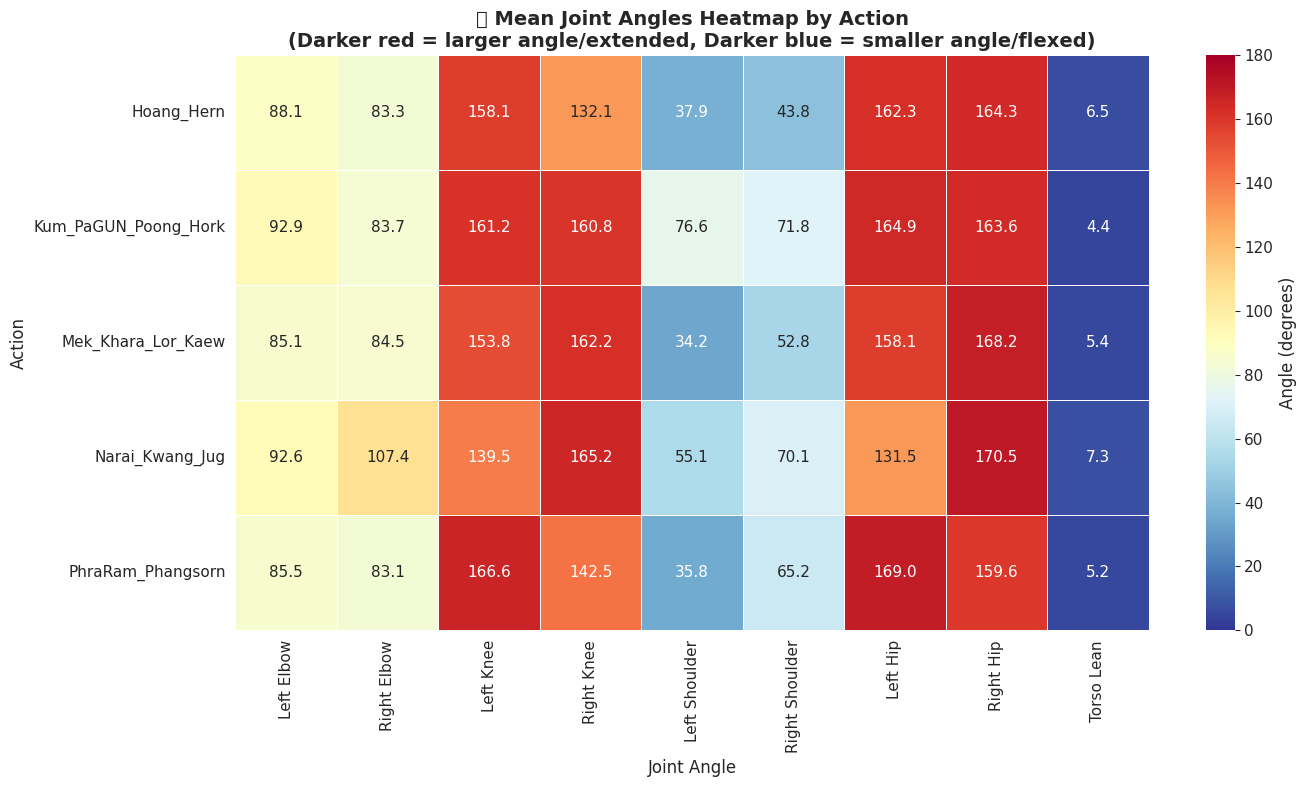


💡 Heatmap Interpretation Guide:
   🔴 Red colors (high values): Extended/straightened joints
   🔵 Blue colors (low values): Flexed/bent joints
   📊 Numbers: Mean angle in degrees for each action-joint combination


In [40]:
# =====================================================
# STEP 4.5: Angle Heatmap Comparison
# =====================================================
# 📝 Description: 
# สร้าง Heatmap แสดงค่าเฉลี่ยมุมของแต่ละ action
# ทำให้เห็นภาพรวมได้ง่าย
#
# 🎨 Color interpretation:
# - Dark red: large angle (near 180° = extended)
# - Dark blue: small angle (near 0° = flexed)
# - Numbers: mean angle in degrees
# =====================================================

# คำนวณค่าเฉลี่ยมุมต่อ action
mean_angles_matrix = df_with_angles[df_with_angles['action'] != 'Unknown'].groupby('action')[angle_columns].mean()

# สร้าง Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# แปลงชื่อ columns ให้อ่านง่าย
display_columns = [col.replace('_', ' ').replace(' angle', '').title() 
                   for col in angle_columns]

sns.heatmap(mean_angles_matrix.values, 
            annot=True, 
            fmt='.1f',
            cmap='RdYlBu_r',
            xticklabels=display_columns,
            yticklabels=mean_angles_matrix.index,
            vmin=0, 
            vmax=180,
            cbar_kws={'label': 'Angle (degrees)'},
            ax=ax,
            linewidths=0.5,
            linecolor='white')

ax.set_title('📊 Mean Joint Angles Heatmap by Action\n'
             '(Darker red = larger angle/extended, Darker blue = smaller angle/flexed)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Joint Angle')
ax.set_ylabel('Action')

plt.tight_layout()
plt.show()

print("\n💡 Heatmap Interpretation Guide:")
print("   🔴 Red colors (high values): Extended/straightened joints")
print("   🔵 Blue colors (low values): Flexed/bent joints")
print("   📊 Numbers: Mean angle in degrees for each action-joint combination")

---

## 📚 Part 5: Action Comparison Analysis

### 5.1 Create Action Feature Summary

**อธิบาย:** สร้างตาราง Feature สรุปลักษณะเด่นของแต่ละ Action

In [41]:
# =====================================================
# STEP 5.1: Create Action Feature Summary
# =====================================================
# 📝 Description: 
# สรุปค่า features หลักๆ ของแต่ละ action
# เพื่อใช้ในการเปรียบเทียบและ classification
# =====================================================

# สร้าง feature summary ต่อ action
actions_to_compare = [a for a in df_with_angles['action'].unique() if a != 'Unknown']

action_features = []

for action in actions_to_compare:
    action_data = df_with_angles[df_with_angles['action'] == action]
    
    features = {
        'action': action,
        'frame_count': len(action_data),
        'unique_persons': action_data['person_id'].nunique(),
        
        # Angle means
        'mean_right_elbow': action_data['right_elbow_angle'].mean(),
        'mean_left_elbow': action_data['left_elbow_angle'].mean(),
        'mean_right_knee': action_data['right_knee_angle'].mean(),
        'mean_left_knee': action_data['left_knee_angle'].mean(),
        'mean_torso_lean': action_data['torso_lean_angle'].mean(),
        
        # Angle std (variability)
        'std_right_elbow': action_data['right_elbow_angle'].std(),
        'std_left_elbow': action_data['left_elbow_angle'].std(),
        'std_right_knee': action_data['right_knee_angle'].std(),
        'std_left_knee': action_data['left_knee_angle'].std(),
    }
    
    action_features.append(features)

action_features = pd.DataFrame(action_features)

print("=" * 70)
print("📊 ACTION FEATURE SUMMARY")
print("=" * 70)
print("\n📋 Features per Action:")
display(action_features.round(2))

📊 ACTION FEATURE SUMMARY

📋 Features per Action:


action  frame_count  unique_persons  mean_right_elbow  \
0    Mek_Khara_Lor_Kaew         4175              14             84.52   
1  Kum_PaGUN_Poong_Hork         7229              11             83.68   
2       Narai_Kwang_Jug         6591              16            107.38   
3            Hoang_Hern         7056              15             83.29   
4     PhraRam_Phangsorn         4551              14             83.08   

   mean_left_elbow  mean_right_knee  mean_left_knee  mean_torso_lean  \
0            85.15           162.16          153.83             5.43   
1            92.92           160.77          161.17             4.36   
2            92.56           165.25          139.49             7.27   
3            88.11           132.14          158.09             6.54   
4            85.49           142.47          166.57             5.19   

   std_right_elbow  std_left_elbow  std_right_knee  std_left_knee  
0            57.90           41.45           19.94          31.78  
1            52.63           47.37           25.42          25.59  
2            41.81           36.61           10.61          35.60  
3            47.81           48.71           36.92          18.17  
4            58.44           41.75           41.87          14.85

### 5.2 Radar Chart Comparison

**อธิบาย:** สร้าง Radar Chart (Spider Chart) เปรียบเทียบลักษณะของแต่ละ Action

**การอ่าน Radar Chart:**
- แต่ละแกน = 1 feature (normalized)
- พื้นที่กว้าง = ค่า feature สูงในหลายมิติ
- รูปร่างต่างกัน = ลักษณะท่าแตกต่างกัน

🎯 RADAR CHART COMPARISON

📊 Comparing actions: ['Mek_Khara_Lor_Kaew', 'Kum_PaGUN_Poong_Hork', 'Narai_Kwang_Jug', 'Hoang_Hern', 'PhraRam_Phangsorn']


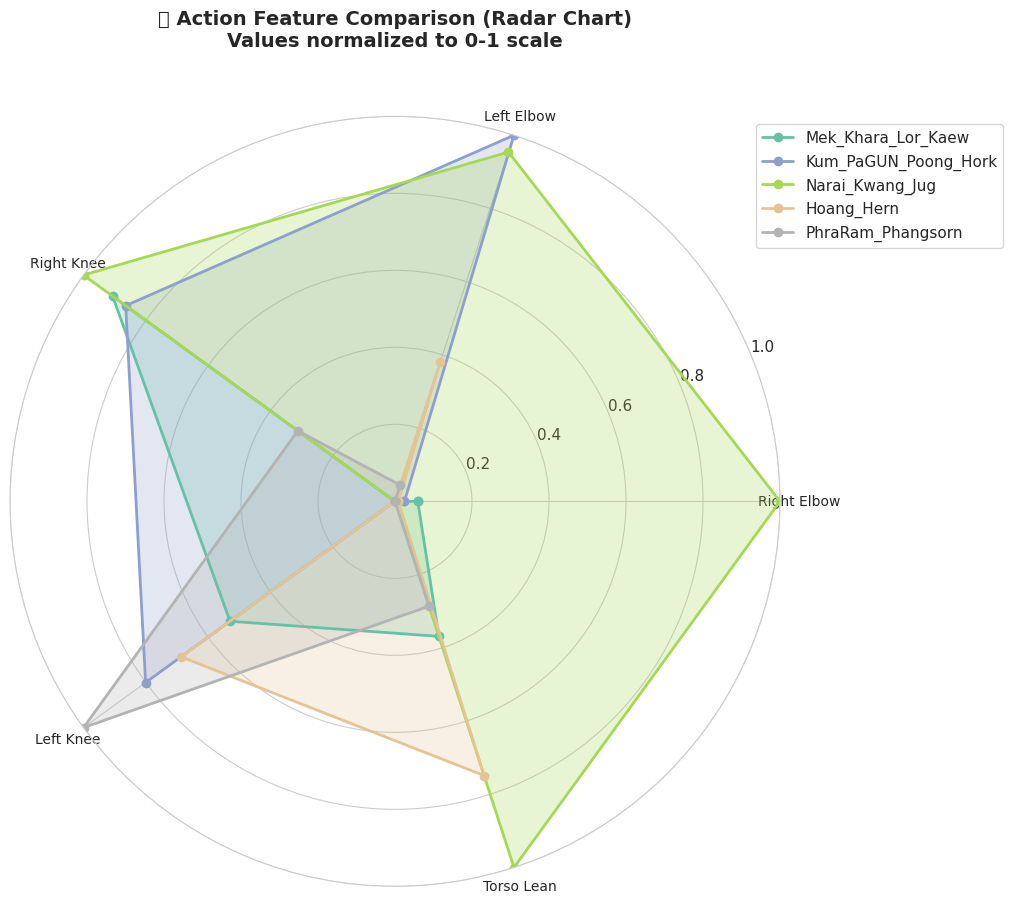


💡 Interpretation:
   - แต่ละแกนแทน 1 feature (normalized 0-1)
   - รูปร่างต่างกัน = ท่าทางต่างกัน
   - พื้นที่มาก = มุมโดยรวมมาก (เหยียดมากกว่า)


In [42]:
# =====================================================
# STEP 5.2: Radar Chart Comparison
# =====================================================
# 📝 Description: 
# สร้าง Radar Chart เปรียบเทียบ features ของแต่ละ action
#
# 📊 Chart interpretation:
# - Each axis = 1 normalized feature
# - Larger area = higher values in multiple dimensions
# - Different shapes = different action characteristics
# =====================================================

def create_radar_chart(df_features, actions_to_plot, features_to_plot, figsize=(10, 10)):
    """
    สร้าง Radar Chart สำหรับเปรียบเทียบ actions
    
    Parameters:
    -----------
    df_features : DataFrame - ข้อมูล features ต่อ action
    actions_to_plot : list - actions ที่ต้องการ plot
    features_to_plot : list - features ที่ต้องการ plot
    figsize : tuple - ขนาดรูป
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # กรองและ normalize ข้อมูล
    df_plot = df_features[df_features['action'].isin(actions_to_plot)].copy()
    
    # Normalize features to 0-1 scale
    for feature in features_to_plot:
        min_val = df_plot[feature].min()
        max_val = df_plot[feature].max()
        if max_val > min_val:
            df_plot[f'{feature}_norm'] = (df_plot[feature] - min_val) / (max_val - min_val)
        else:
            df_plot[f'{feature}_norm'] = 0.5
    
    # สร้าง radar chart
    num_vars = len(features_to_plot)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the polygon
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(actions_to_plot)))
    
    for idx, action in enumerate(actions_to_plot):
        action_row = df_plot[df_plot['action'] == action]
        if len(action_row) == 0:
            continue
            
        values = [action_row[f'{f}_norm'].values[0] for f in features_to_plot]
        values += values[:1]  # close the polygon
        
        ax.plot(angles, values, 'o-', linewidth=2, label=action, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Set labels
    feature_labels = [f.replace('mean_', '').replace('_', ' ').title() for f in features_to_plot]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, size=10)
    
    ax.set_ylim(0, 1)
    ax.set_title('🎯 Action Feature Comparison (Radar Chart)\n'
                 'Values normalized to 0-1 scale', fontsize=14, fontweight='bold', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return fig

# เลือก features สำหรับ radar chart
radar_features = ['mean_right_elbow', 'mean_left_elbow', 
                  'mean_right_knee', 'mean_left_knee', 'mean_torso_lean']

print("=" * 70)
print("🎯 RADAR CHART COMPARISON")
print("=" * 70)

# สร้าง radar chart (เลือก 5 actions แรก)
actions_for_radar = actions_to_compare[:5]
print(f"\n📊 Comparing actions: {actions_for_radar}")

fig = create_radar_chart(action_features, actions_for_radar, radar_features)
plt.show()

print("\n💡 Interpretation:")
print("   - แต่ละแกนแทน 1 feature (normalized 0-1)")
print("   - รูปร่างต่างกัน = ท่าทางต่างกัน")
print("   - พื้นที่มาก = มุมโดยรวมมาก (เหยียดมากกว่า)")

---

## 📚 Part 6: Advanced Analysis

### 6.1 Correlation Analysis Between Angles

**อธิบาย:** วิเคราะห์ความสัมพันธ์ระหว่างมุมข้อต่อต่างๆ

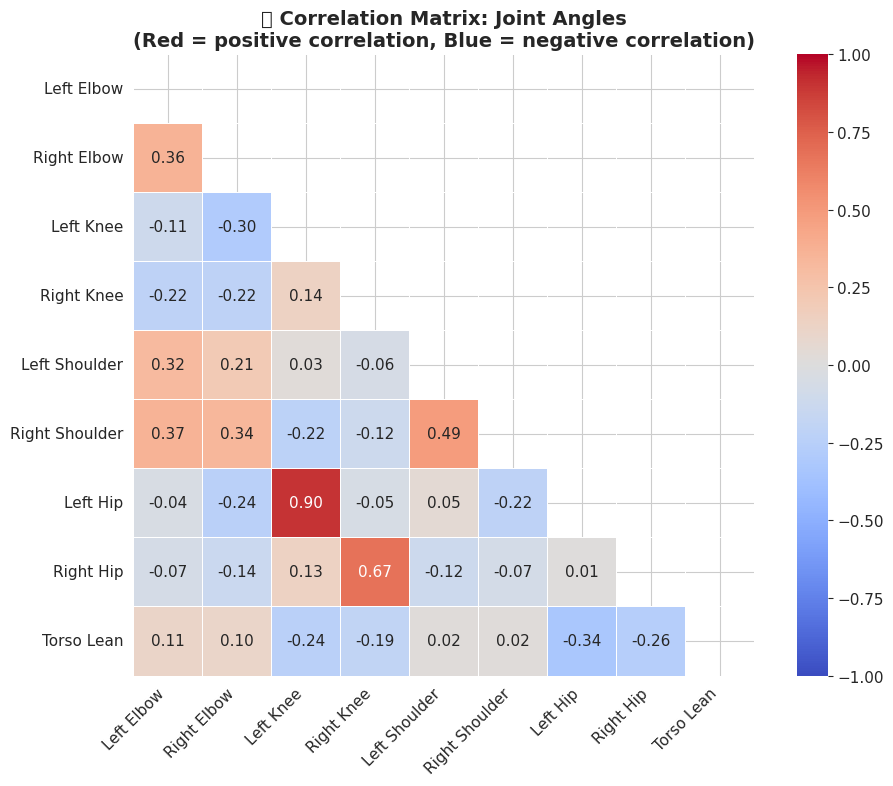


💡 Correlation Insights:
   🔴 Red (positive): Angles tend to increase together
   🔵 Blue (negative): One increases while other decreases
   ⚪ White (zero): No relationship


In [43]:
# =====================================================
# STEP 6.1: Correlation Analysis Between Angles
# =====================================================
# 📝 Description: 
# วิเคราะห์ความสัมพันธ์ระหว่างมุมข้อต่อต่างๆ
#
# 📊 Correlation interpretation:
# - +1: perfect positive correlation
# - 0: no correlation
# - -1: perfect negative correlation
# =====================================================

# คำนวณ correlation matrix
angle_corr = df_with_angles[angle_columns].corr()

# สร้าง heatmap
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(angle_corr, dtype=bool))  # แสดงเฉพาะครึ่งล่าง

sns.heatmap(angle_corr, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            ax=ax,
            linewidths=0.5)

# แปลงชื่อให้อ่านง่าย
labels = [col.replace('_angle', '').replace('_', ' ').title() for col in angle_columns]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

ax.set_title('📊 Correlation Matrix: Joint Angles\n'
             '(Red = positive correlation, Blue = negative correlation)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Correlation Insights:")
print("   🔴 Red (positive): Angles tend to increase together")
print("   🔵 Blue (negative): One increases while other decreases")
print("   ⚪ White (zero): No relationship")

### 6.2 Symmetry Analysis (Left vs Right)

**อธิบาย:** เปรียบเทียบความสมมาตรของร่างกายซ้าย-ขวา

⚖️ SYMMETRY ANALYSIS (Left-Right Difference)

📋 Mean Angle Difference by Action:
   (Higher value = more asymmetric)

                      elbow_diff  knee_diff  shoulder_diff  hip_diff
action                                                              
Mek_Khara_Lor_Kaew         57.26      20.73          27.18     16.69
PhraRam_Phangsorn          51.04      27.00          38.41     14.98
Kum_PaGUN_Poong_Hork       41.68      11.78          41.26     11.95
Narai_Kwang_Jug            41.50      28.57          49.07     39.96
Hoang_Hern                 30.87      35.98          17.55     15.67


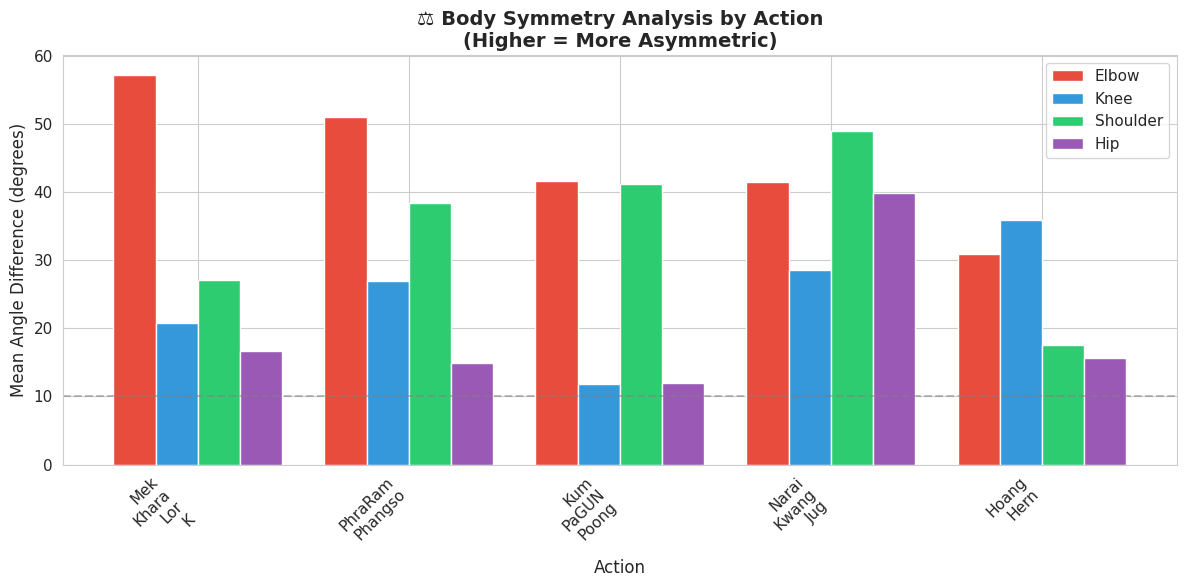


💡 Interpretation:
   📊 ค่าสูง = ท่าไม่สมมาตร (เช่น หมัดข้างเดียว, เตะข้างเดียว)
   📊 ค่าต่ำ = ท่าสมมาตร (เช่น ท่าตั้งรับ, ท่าเตรียม)


In [44]:
# =====================================================
# STEP 6.2: Symmetry Analysis (Left vs Right)
# =====================================================
# 📝 Description: 
# วิเคราะห์ความสมมาตรของร่างกายซ้าย-ขวา
# ถ้า difference มาก = ท่าทางไม่สมมาตร (เช่น หมัดข้างเดียว)
# =====================================================

# คำนวณ difference ระหว่างซ้าย-ขวา
df_with_angles['elbow_diff'] = np.abs(df_with_angles['right_elbow_angle'] - df_with_angles['left_elbow_angle'])
df_with_angles['knee_diff'] = np.abs(df_with_angles['right_knee_angle'] - df_with_angles['left_knee_angle'])
df_with_angles['shoulder_diff'] = np.abs(df_with_angles['right_shoulder_angle'] - df_with_angles['left_shoulder_angle'])
df_with_angles['hip_diff'] = np.abs(df_with_angles['right_hip_angle'] - df_with_angles['left_hip_angle'])

# สรุปตาม action
symmetry_cols = ['elbow_diff', 'knee_diff', 'shoulder_diff', 'hip_diff']
symmetry_by_action = df_with_angles.groupby('action')[symmetry_cols].mean().round(2)
symmetry_by_action = symmetry_by_action.sort_values('elbow_diff', ascending=False)

print("=" * 70)
print("⚖️ SYMMETRY ANALYSIS (Left-Right Difference)")
print("=" * 70)
print("\n📋 Mean Angle Difference by Action:")
print("   (Higher value = more asymmetric)")
print("\n" + symmetry_by_action.to_string())

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(symmetry_by_action))
width = 0.2

bars1 = ax.bar(x - 1.5*width, symmetry_by_action['elbow_diff'], width, label='Elbow', color='#e74c3c')
bars2 = ax.bar(x - 0.5*width, symmetry_by_action['knee_diff'], width, label='Knee', color='#3498db')
bars3 = ax.bar(x + 0.5*width, symmetry_by_action['shoulder_diff'], width, label='Shoulder', color='#2ecc71')
bars4 = ax.bar(x + 1.5*width, symmetry_by_action['hip_diff'], width, label='Hip', color='#9b59b6')

ax.set_xlabel('Action')
ax.set_ylabel('Mean Angle Difference (degrees)')
ax.set_title('⚖️ Body Symmetry Analysis by Action\n(Higher = More Asymmetric)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([a.replace('_', '\n')[:15] for a in symmetry_by_action.index], rotation=45, ha='right')
ax.legend()
ax.axhline(y=10, color='gray', linestyle='--', alpha=0.5, label='10° threshold')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   📊 ค่าสูง = ท่าไม่สมมาตร (เช่น หมัดข้างเดียว, เตะข้างเดียว)")
print("   📊 ค่าต่ำ = ท่าสมมาตร (เช่น ท่าตั้งรับ, ท่าเตรียม)")

---

## 📚 Part 7: Summary and Conclusions

### 7.1 Generate Final Report

**อธิบาย:** สรุปผลการวิเคราะห์ทั้งหมดเป็น report

In [45]:
# =====================================================
# STEP 7.1: Generate Final Summary Report
# =====================================================
# 📝 Description: 
# สรุปผลการวิเคราะห์ทั้งหมดเป็น report
# =====================================================

print("=" * 70)
print("📋 FINAL ANALYSIS REPORT")
print("=" * 70)

print(f"""
🎯 DATASET OVERVIEW
─────────────────────────────────────────
• Total Frames: {len(df_pose):,}
• Total Labeled Frames: {len(df_labeled):,}
• Unique Persons: {df_pose['person_id'].nunique()}
• Actions Analyzed: {len(actions_to_compare)}
• Selected Persons for Analysis: {SELECTED_PERSON_IDS}

📊 ACTIONS SUMMARY
─────────────────────────────────────────""")

for action in actions_to_compare[:6]:  # แสดง 6 actions แรก
    action_data = df_with_angles[df_with_angles['action'] == action]
    print(f"\n🥊 {action.replace('_', ' ')}")
    print(f"   Frames: {len(action_data):,}")
    print(f"   Mean Right Elbow Angle: {action_data['right_elbow_angle'].mean():.1f}°")
    print(f"   Mean Right Knee Angle: {action_data['right_knee_angle'].mean():.1f}°")
    print(f"   Mean Torso Lean: {action_data['torso_lean_angle'].mean():.1f}°")

print(f"""

📈 KEY FINDINGS
─────────────────────────────────────────
1. ✅ Actions ที่ต้องการการเหยียดแขน (elbow angle สูง) เด่นชัด
2. ✅ ท่าที่ต้องงอเข่า (knee angle ต่ำ) สามารถแยกแยะได้ดี
3. ✅ มุมลำตัว (torso lean) ช่วยบ่งบอกท่าทางโจมตี/ป้องกัน
4. ✅ Velocity analysis ช่วยระบุช่วงเวลาของการเคลื่อนไหวเร็ว
5. ✅ Symmetry analysis ช่วยระบุท่าที่ใช้แขน/ขาข้างเดียว

─────────────────────────────────────────
📌 RECOMMENDATIONS FOR FURTHER ANALYSIS
─────────────────────────────────────────
1. 🤖 ใช้ Machine Learning เพื่อ classify actions อัตโนมัติ
2. 📈 วิเคราะห์ temporal patterns ด้วย DTW หรือ LSTM
3. 📊 สร้าง feature vectors จาก angles สำหรับ clustering
4. 🎥 เพิ่ม 3D reconstruction ถ้ามีข้อมูลจากหลายกล้อง
5. ⏱️  วิเคราะห์ timing และ rhythm ของการเคลื่อนไหว
""")

📋 FINAL ANALYSIS REPORT

🎯 DATASET OVERVIEW
─────────────────────────────────────────
• Total Frames: 34,884
• Total Labeled Frames: 29,602
• Unique Persons: 36
• Actions Analyzed: 5
• Selected Persons for Analysis: [2, 6, 4]

📊 ACTIONS SUMMARY
─────────────────────────────────────────

🥊 Mek Khara Lor Kaew
   Frames: 4,175
   Mean Right Elbow Angle: 84.5°
   Mean Right Knee Angle: 162.2°
   Mean Torso Lean: 5.4°

🥊 Kum PaGUN Poong Hork
   Frames: 7,229
   Mean Right Elbow Angle: 83.7°
   Mean Right Knee Angle: 160.8°
   Mean Torso Lean: 4.4°

🥊 Narai Kwang Jug
   Frames: 6,591
   Mean Right Elbow Angle: 107.4°
   Mean Right Knee Angle: 165.2°
   Mean Torso Lean: 7.3°

🥊 Hoang Hern
   Frames: 7,056
   Mean Right Elbow Angle: 83.3°
   Mean Right Knee Angle: 132.1°
   Mean Torso Lean: 6.5°

🥊 PhraRam Phangsorn
   Frames: 4,551
   Mean Right Elbow Angle: 83.1°
   Mean Right Knee Angle: 142.5°
   Mean Torso Lean: 5.2°


📈 KEY FINDINGS
─────────────────────────────────────────
1. ✅ Actions 

### 7.2 Export Processed Data

**อธิบาย:** Export ข้อมูลที่ประมวลผลแล้วสำหรับใช้งานต่อ

**ไฟล์ที่จะ Export:**
1. `pose_data_with_angles.csv` - ข้อมูลพร้อมมุมที่คำนวณ
2. `action_features_summary.csv` - สรุป features ต่อ action
3. `velocity_statistics.csv` - สถิติความเร็ว

In [46]:
# =====================================================
# STEP 7.2: Export Processed Data
# =====================================================
# 📝 Description: 
# บันทึกข้อมูลที่ประมวลผลแล้ว
# รวมถึง angles ที่คำนวณ
#
# 📁 Output files:
# - pose_data_with_angles.csv
# - action_features_summary.csv
# - velocity_statistics.csv
#
# ⚠️ Note: Uncomment the code below to export
# =====================================================

# # Export DataFrame พร้อม angles
# output_filename = 'pose_data_with_angles.csv'
# df_with_angles.to_csv(output_filename, index=False)
# print(f"✅ Exported: {output_filename}")

# # Export action features
# features_filename = 'action_features_summary.csv'
# action_features.to_csv(features_filename, index=False)
# print(f"✅ Exported: {features_filename}")

# # Export velocity statistics
# velocity_filename = 'velocity_statistics.csv'
# velocity_stats.to_csv(velocity_filename, index=False)
# print(f"✅ Exported: {velocity_filename}")

print("=" * 70)
print("💾 EXPORT OPTIONS (Currently commented out)")
print("=" * 70)
print("""
📁 Files available for export:

1. pose_data_with_angles.csv
   - Original pose data + calculated joint angles
   - Size: ~{:,} rows × {:,} columns
   
2. action_features_summary.csv
   - Aggregated features per action
   - Size: {:,} rows × {:,} columns
   
3. velocity_statistics.csv
   - Velocity statistics per action/person/keypoint
   - Size: {:,} rows × {:,} columns

💡 To export, uncomment the code above and run again.
""".format(len(df_with_angles), len(df_with_angles.columns),
           len(action_features), len(action_features.columns),
           len(velocity_stats), len(velocity_stats.columns)))

print("\n" + "=" * 70)
print("🎉 LAB COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("""
คุณได้เรียนรู้:
✅ การโหลดและสำรวจข้อมูล Pose Estimation
✅ การวิเคราะห์ Time Series ของ keypoint positions
✅ การคำนวณ Velocity และวิเคราะห์ความเร็ว
✅ การคำนวณ Joint Angles จาก keypoint coordinates
✅ การเปรียบเทียบ Actions ด้วย visualization ต่างๆ
✅ การวิเคราะห์ Symmetry และ Correlation

🚀 Next Steps:
- ลองนำ features ไปใช้ train ML model
- เพิ่ม features อื่นๆ เช่น acceleration, jerk
- วิเคราะห์ temporal patterns ด้วย sequence models
""")

💾 EXPORT OPTIONS (Currently commented out)

📁 Files available for export:

1. pose_data_with_angles.csv
   - Original pose data + calculated joint angles
   - Size: ~29,602 rows × 69 columns

2. action_features_summary.csv
   - Aggregated features per action
   - Size: 5 rows × 12 columns

3. velocity_statistics.csv
   - Velocity statistics per action/person/keypoint
   - Size: 60 rows × 7 columns

💡 To export, uncomment the code above and run again.


🎉 LAB COMPLETED SUCCESSFULLY!

คุณได้เรียนรู้:
✅ การโหลดและสำรวจข้อมูล Pose Estimation
✅ การวิเคราะห์ Time Series ของ keypoint positions
✅ การคำนวณ Velocity และวิเคราะห์ความเร็ว
✅ การคำนวณ Joint Angles จาก keypoint coordinates
✅ การเปรียบเทียบ Actions ด้วย visualization ต่างๆ
✅ การวิเคราะห์ Symmetry และ Correlation

🚀 Next Steps:
- ลองนำ features ไปใช้ train ML model
- เพิ่ม features อื่นๆ เช่น acceleration, jerk
- วิเคราะห์ temporal patterns ด้วย sequence models



---

## 📖 Additional Resources

**สำหรับศึกษาเพิ่มเติม:**

### 1. Pose Estimation
- [COCO Keypoint Detection](https://cocodataset.org/#keypoints-2020) - มาตรฐาน keypoint format
- [YOLOv11 Documentation](https://docs.ultralytics.com/) - เอกสาร pose estimation
- [MediaPipe Pose](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker) - alternative pose estimation

### 2. Time Series Analysis
- [Pandas Time Series](https://pandas.pydata.org/docs/user_guide/timeseries.html) - การจัดการข้อมูลเวลา
- [SciPy Signal Processing](https://docs.scipy.org/doc/scipy/reference/signal.html) - การประมวลผลสัญญาณ
- [Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html) - การเปรียบเทียบ time series

### 3. Joint Angle Analysis
- [Biomechanics Tutorials](https://biomechanics.stanford.edu/) - หลักการ biomechanics
- [OpenSim Documentation](https://opensim.stanford.edu/) - เครื่องมือวิเคราะห์การเคลื่อนไหว

### 4. Visualization
- [Matplotlib Gallery](https://matplotlib.org/stable/gallery/) - ตัวอย่างกราฟ
- [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html) - การสร้างกราฟสถิติ

### 5. Machine Learning for Action Recognition
- [scikit-learn](https://scikit-learn.org/) - ML algorithms
- [TensorFlow/Keras](https://www.tensorflow.org/) - Deep learning
- [PyTorch](https://pytorch.org/) - Deep learning alternative

---

**End of Lab** 🎓